In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import mannwhitneyu, chi2_contingency
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import CategoricalNB, MultinomialNB, GaussianNB, BernoulliNB
from imblearn.pipeline import make_pipeline
from umap import UMAP
import plotly.express as px
from sklearn.linear_model import LassoCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)

Train Test Split

In [50]:
df = pd.read_csv(r'project_data\train.csv', sep=',')
df = df.drop(columns='readmitted_binary')
df = df.set_index(df['encounter_id']).drop(columns='encounter_id') #set encounter id as index
y = df['readmitted_multiclass'] #split in X and y
X = df.drop(columns = 'readmitted_multiclass')

In [51]:
binary_prediction = pd.read_csv("binary_train_pred.csv", index_col=0)
X['binary_prediction'] = binary_prediction.iloc[:,0].replace({1:'Yes', 0:'No'})

In [52]:
y.value_counts() / y.shape[0] #class imbalance ~9:1

readmitted_multiclass
No          0.539123
>30 days    0.349276
<30 days    0.111601
Name: count, dtype: float64

In [53]:

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, 
                                                  random_state = 0,
                                                  stratify = y, 
                                                  shuffle = True)

X_train_id = X_train.index #save indicies for later on
X_val_id = X_val.index

In [54]:
X_train.head()

country  patient_id             race  gender      age    weight  \
encounter_id                                                                   
369071           USA    63357426        Caucasian  Female  [40-50)  [75-100)   
582754           USA    20711916        Caucasian  Female  [80-90)         ?   
969219           USA    36151272        Caucasian  Female  [50-60)         ?   
981571           USA    85317894        Caucasian  Female  [80-90)         ?   
847718           USA     6193503  AfricanAmerican    Male  [40-50)         ?   

             payer_code  outpatient_visits_in_previous_year  \
encounter_id                                                  
369071               CP                                   2   
582754                ?                                   0   
969219               BC                                   0   
981571               MC                                   1   
847718                ?                                   0   

              emergency_visits_in_previous_year  \
encounter_id                                      
369071                                        1   
582754                                        0   
969219                                        0   
981571                                        0   
847718                                        0   

              inpatient_visits_in_previous_year  ... primary_diagnosis  \
encounter_id                                     ...                     
369071                                        2  ...               307   
582754                                        0  ...               427   
969219                                        0  ...               620   
981571                                        0  ...               991   
847718                                        1  ...               428   

             secondary_diagnosis  additional_diagnosis number_diagnoses  \
encounter_id                                                              
369071                       296                   300                9   
582754                       428                   414                8   
969219                       239                   276                8   
981571                       276                  E901                9   
847718                       414                   401                6   

             glucose_test_result  a1c_test_result  \
encounter_id                                        
369071                       NaN              NaN   
582754                       NaN              NaN   
969219                       NaN              NaN   
981571                       NaN              NaN   
847718                       NaN              NaN   

              change_in_meds_during_hospitalization  prescribed_diabetes_meds  \
encounter_id                                                                    
369071                                           No                       Yes   
582754                                           No                       Yes   
969219                                           No                        No   
981571                                           No                        No   
847718                                           Ch                       Yes   

                 medication binary_prediction  
encounter_id                                   
369071        ['metformin']               Yes  
582754          ['insulin']               Yes  
969219                   []                No  
981571                   []               Yes  
847718          ['insulin']               Yes  

[5 rows x 29 columns]

In [55]:
print(X_train['patient_id'].duplicated().sum()) # duplicated patient ids, good to know maybe for feature engineering later on, for now we drop it
patient_id = X_train['patient_id'] #since we dont expect the patient id to be a relevant feature
X_train.drop(columns='patient_id', inplace=True)#but keep it for later if we need it

12015


In [56]:
numerical_features = X_train.select_dtypes(include=np.number).columns

In [57]:
def bar_charts_numerical(df, feature, target, num_bins=10):

    df['binned_values'] = pd.cut(df[feature], bins=num_bins, precision=2)
    
    df['binned_values'] = df['binned_values'].apply(lambda x: x.mid)
    
    cont_tab = pd.crosstab(df['binned_values'], df[target], margins=True)
    categories = cont_tab.index[:-1]
        
    fig = plt.figure(figsize=(15, 6))
    
    plt.subplot(121)
    bars = []
    bottom = np.zeros(len(categories))
    for i, class_label in enumerate(cont_tab.columns[:-1]):
        bars.append(plt.bar(categories, cont_tab.iloc[:-1, i].values, 0.55, bottom=bottom))
        bottom += cont_tab.iloc[:-1, i].values
    
    plt.legend([bar[0] for bar in bars], cont_tab.columns[:-1])
    plt.title("Frequency bar chart")
    plt.xlabel(feature)
    plt.ylabel("$Frequency$")

    obs_pct = np.divide(cont_tab.iloc[:-1, :-1].values.T, cont_tab.iloc[:-1, -1].values).T

    plt.subplot(122)
    bars = []
    bottom = np.zeros(len(categories))
    for i, class_label in enumerate(cont_tab.columns[:-1]):
        bars.append(plt.bar(categories, obs_pct[:, i], 0.55, bottom=bottom))
        bottom += obs_pct[:, i]

    plt.legend([bar[0] for bar in bars], cont_tab.columns[:-1])
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.ylabel("$p$")
    

    df.drop('binned_values', axis=1, inplace=True)
    
    plt.show()


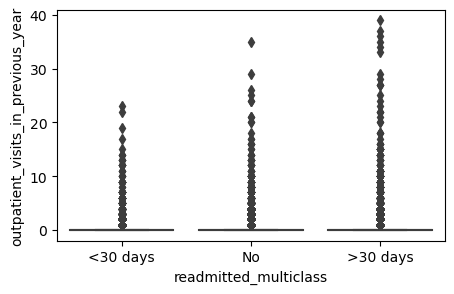

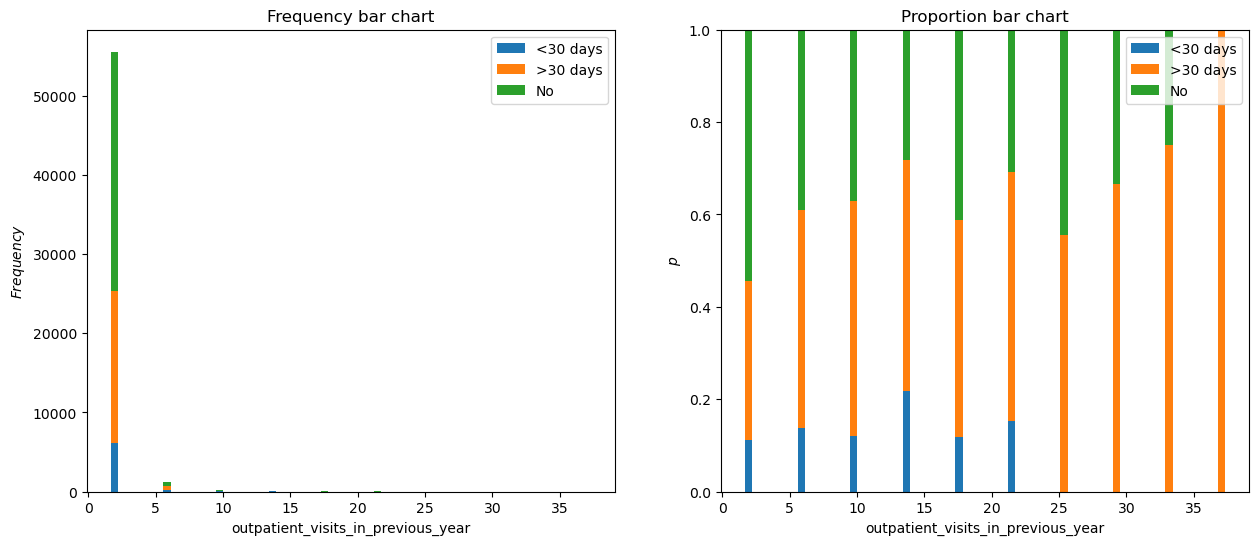

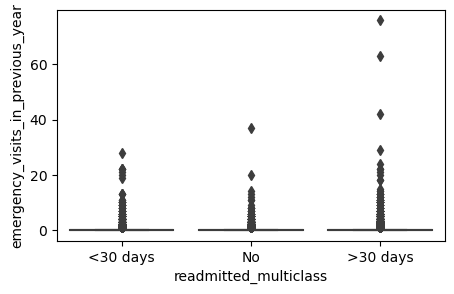

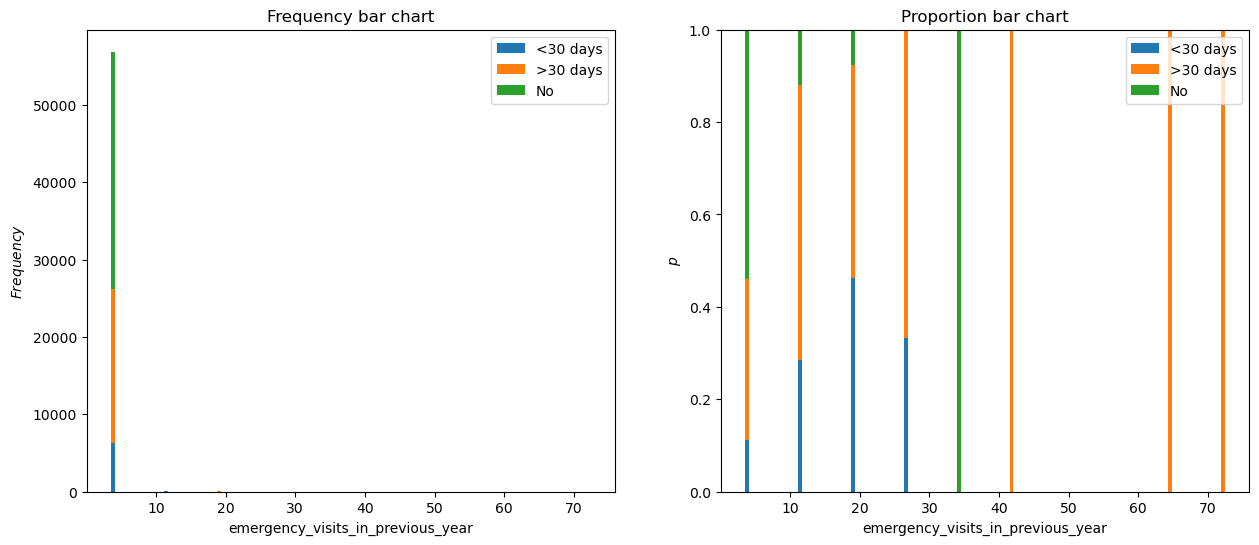

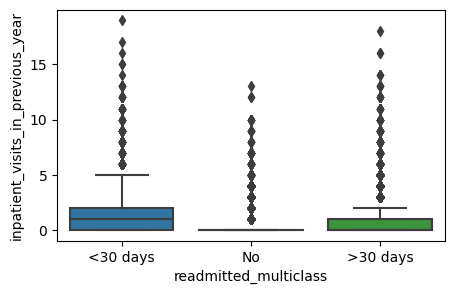

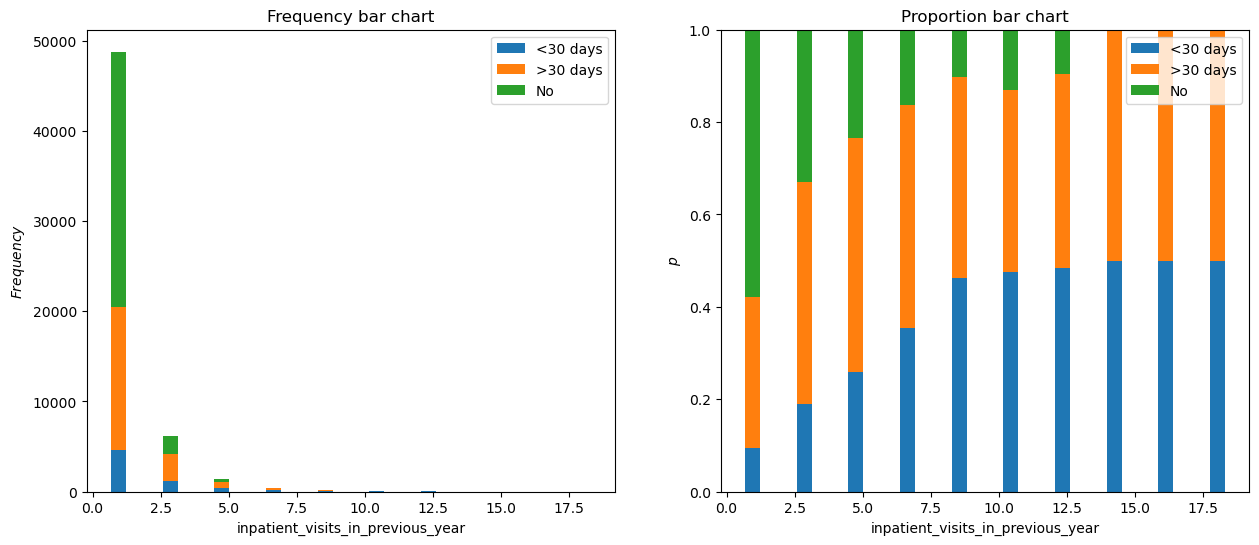

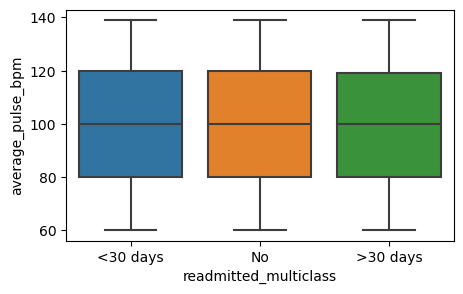

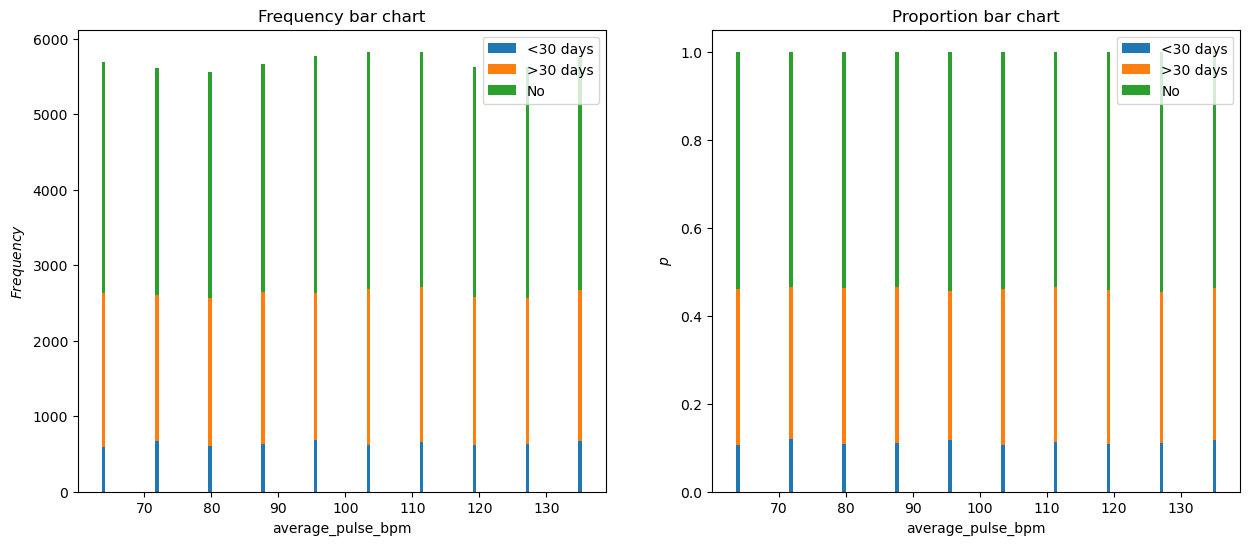

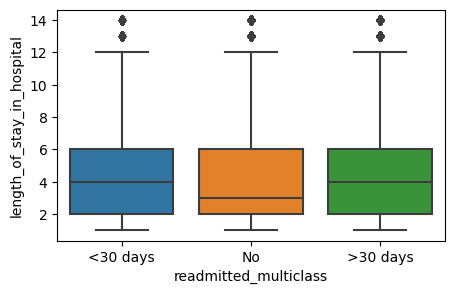

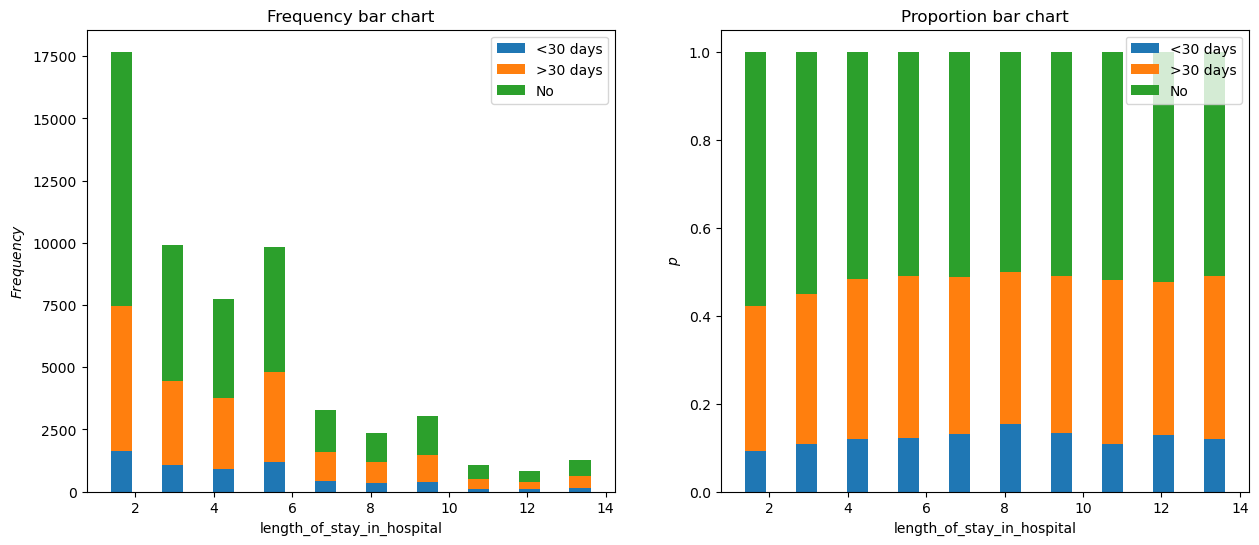

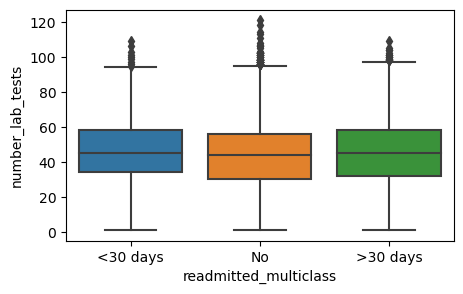

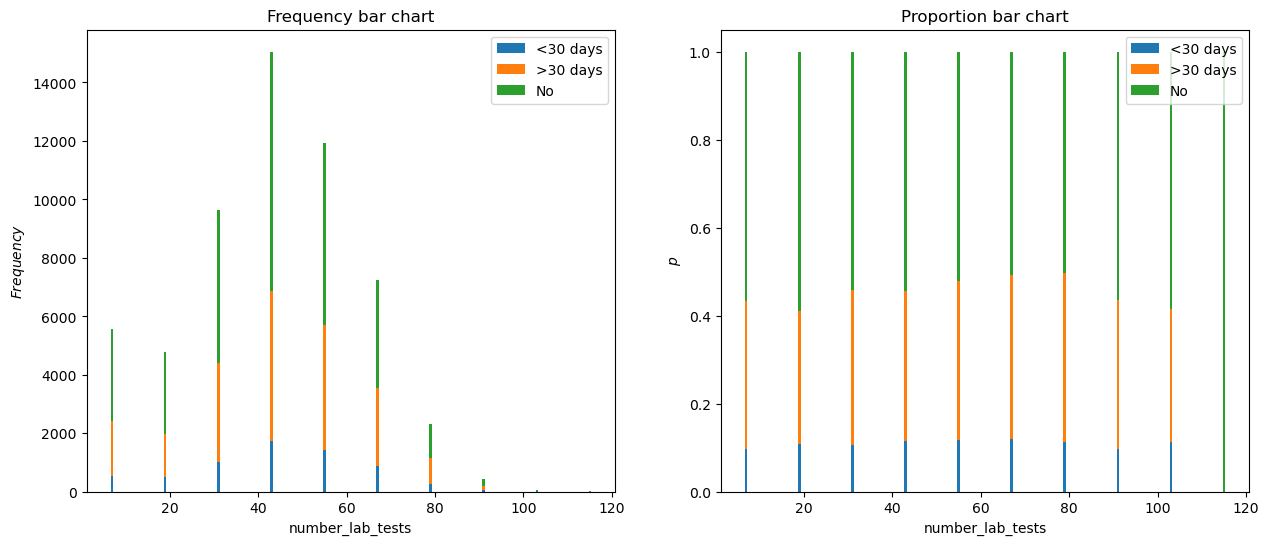

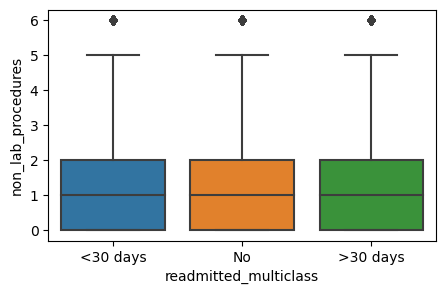

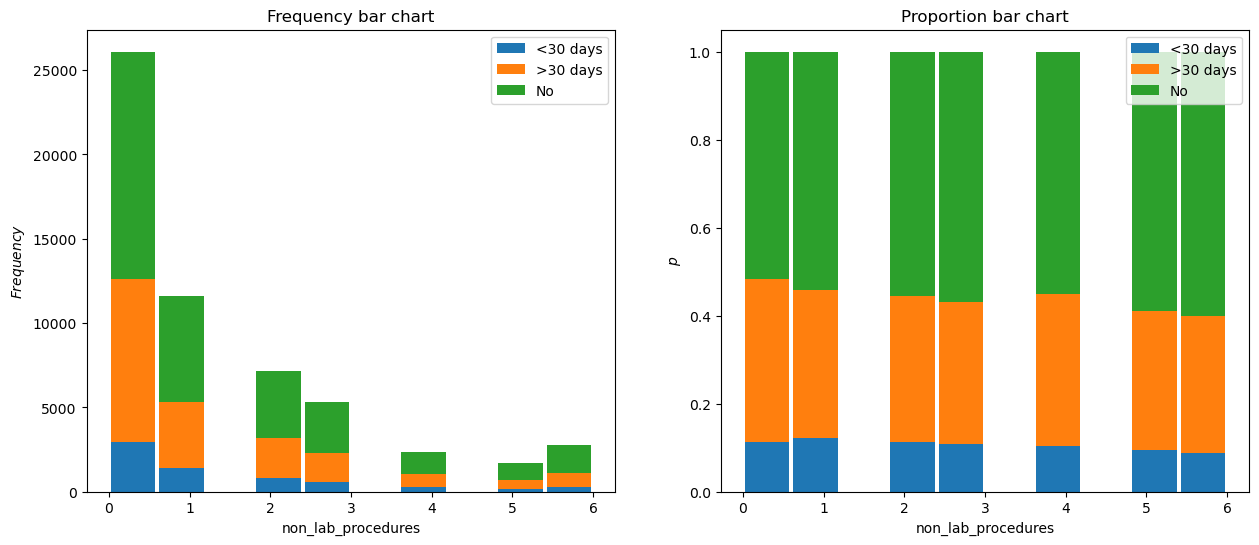

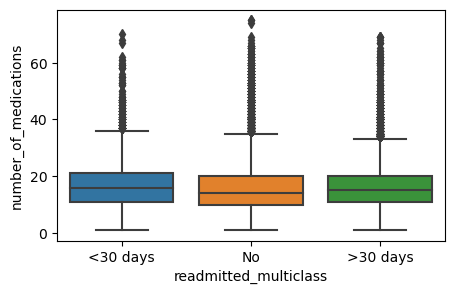

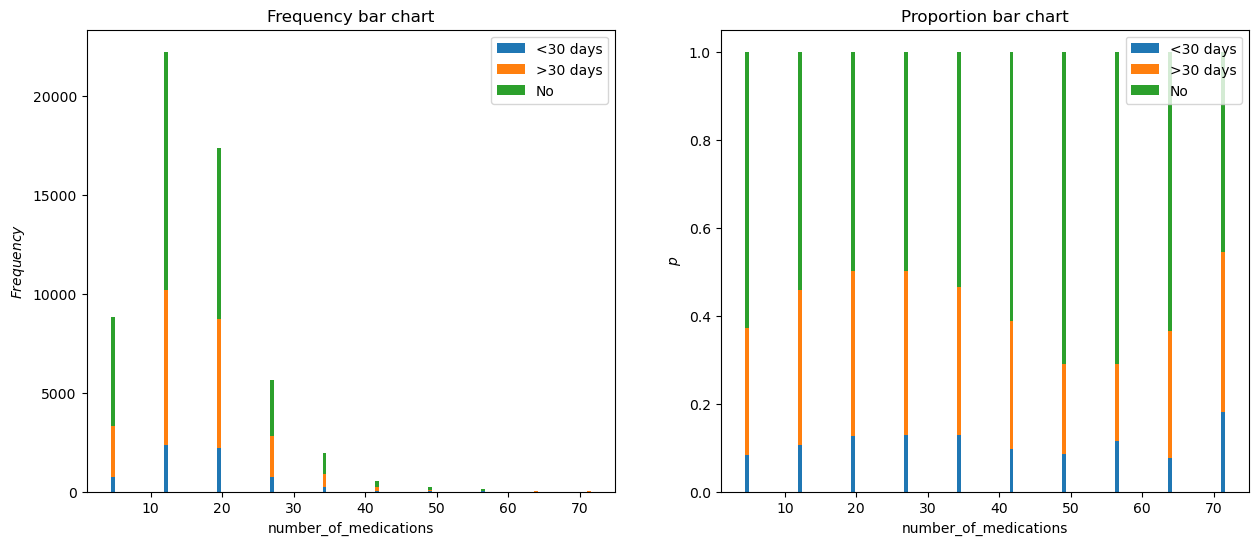

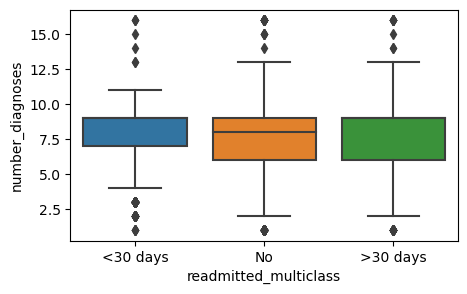

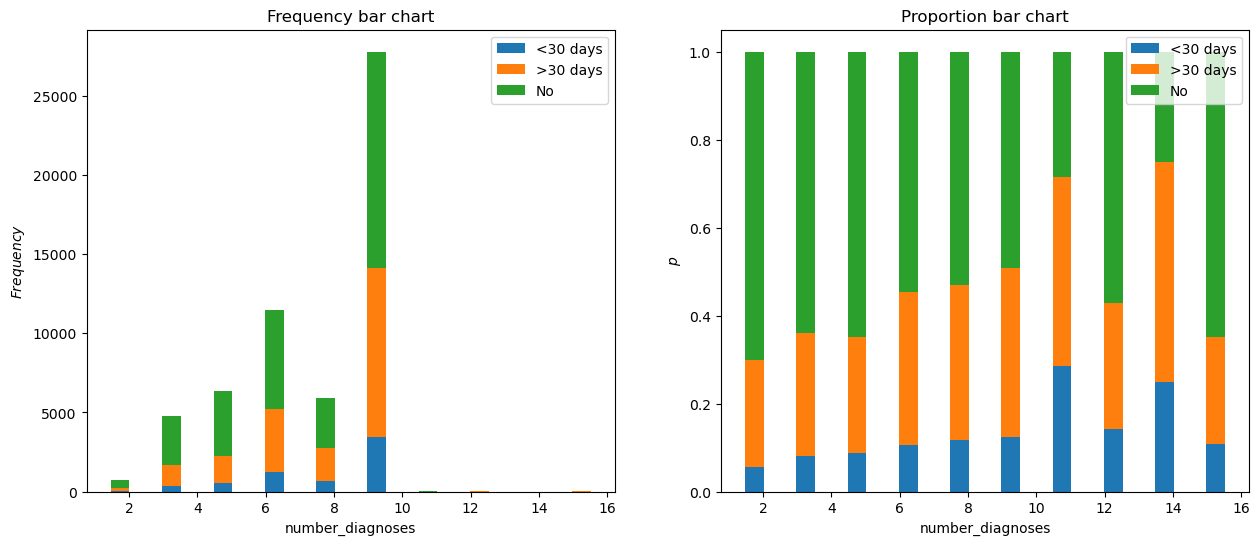

In [58]:
#for the multiclass we have a look at the correlation with our target variable again aswell

all_train = X_train.join(y_train)

for col in numerical_features:
    plt.figure(figsize=(5, 3))
    sns.boxplot(y=X_train[col], x = y_train)
    plt.show()
    bar_charts_numerical(all_train, col, 'readmitted_multiclass', num_bins=10)

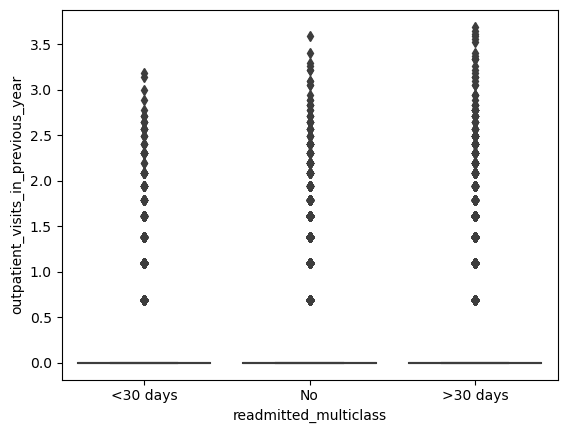

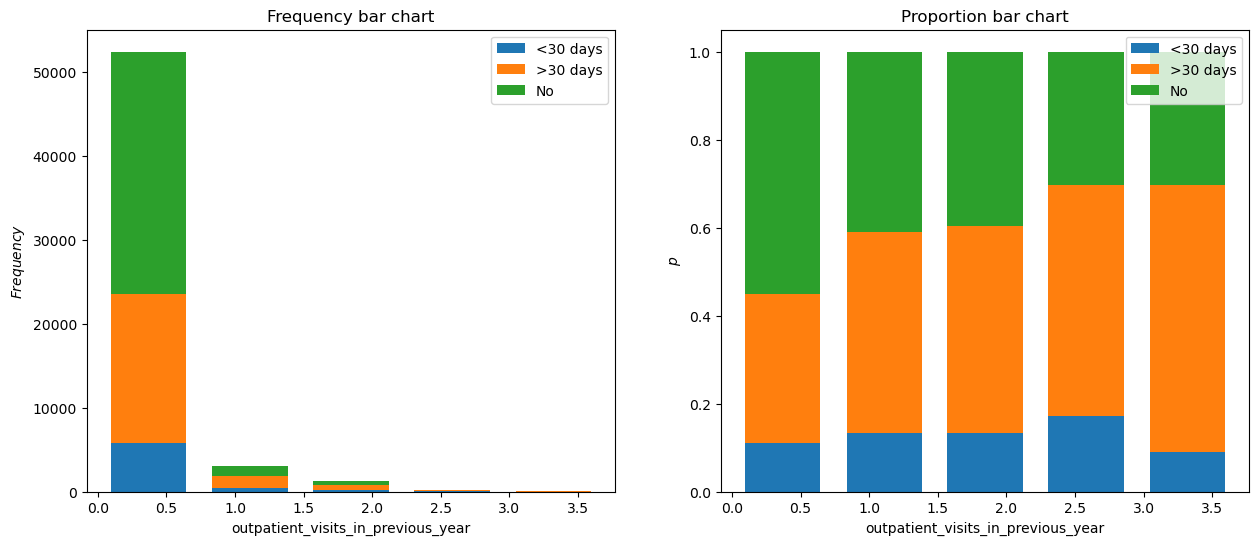

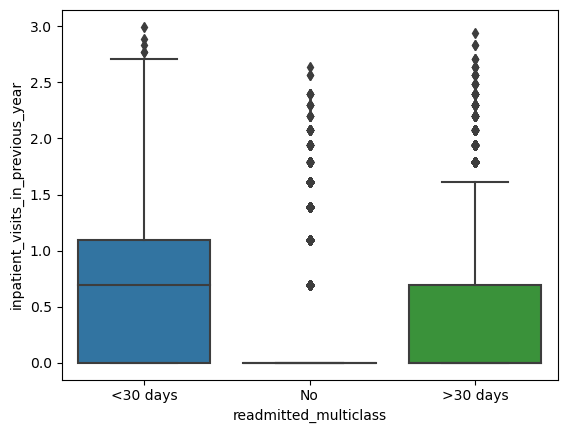

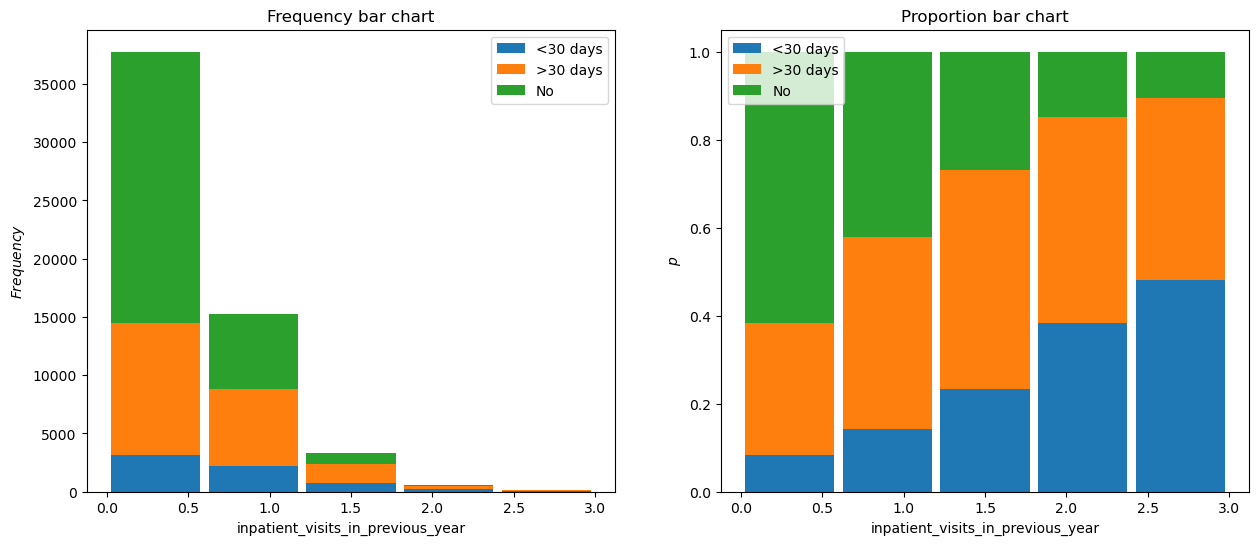

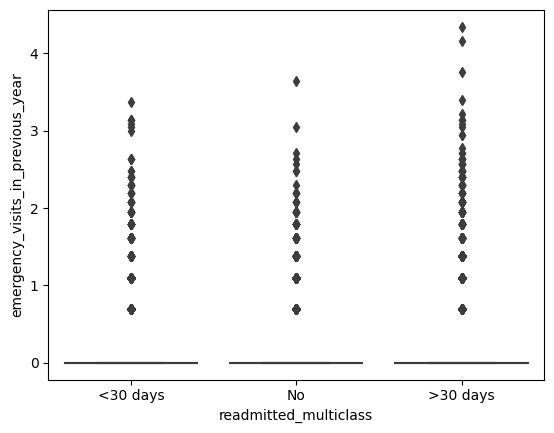

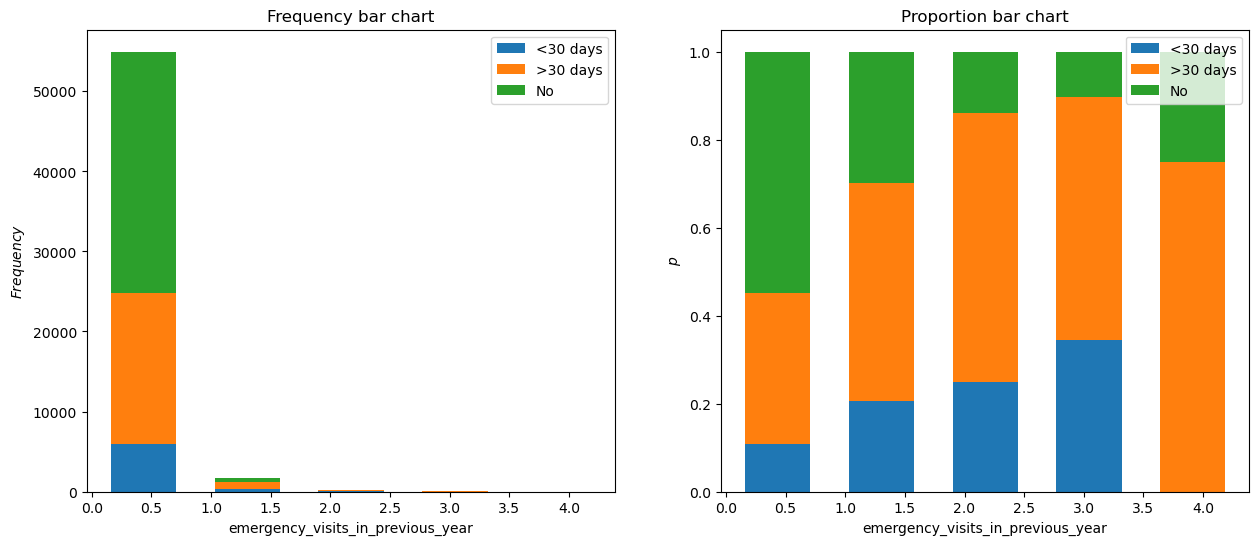

In [59]:
all_train['outpatient_visits_in_previous_year'] = np.log1p(all_train['outpatient_visits_in_previous_year'])
all_train['inpatient_visits_in_previous_year'] = np.log1p(all_train['inpatient_visits_in_previous_year'])
all_train['emergency_visits_in_previous_year'] = np.log1p(all_train['emergency_visits_in_previous_year'])

for col in ['outpatient_visits_in_previous_year','inpatient_visits_in_previous_year','emergency_visits_in_previous_year']:
    sns.boxplot(y=all_train[col], x = all_train['readmitted_multiclass'])
    bar_charts_numerical(all_train, col, 'readmitted_multiclass', num_bins=5)
    plt.show()

Preprocessing numericals

In [60]:
X_train['outpatient_visits_in_previous_year'] = np.log1p(X_train['outpatient_visits_in_previous_year'])
X_train['inpatient_visits_in_previous_year'] = np.log1p(X_train['inpatient_visits_in_previous_year'])
X_train['emergency_visits_in_previous_year'] = np.log1p(X_train['emergency_visits_in_previous_year'])
 

X_train.loc[X_train['emergency_visits_in_previous_year'] >= 3.2, 'emergency_visits_in_previous_year' ] = 0
X_train.loc[X_train['outpatient_visits_in_previous_year'] >= 3.2, 'outpatient_visits_in_previous_year' ] = 0

In [61]:
#average pulse no outliers

#length of stay in hospittal, correlation for outliers seems to match the correlation for the median based on the visual inspection, set to median
X_train.loc[X_train['length_of_stay_in_hospital']>12, 'length_of_stay_in_hospital'] = 4

#same for number of lab tests
X_train.loc[X_train['number_lab_tests']>96, 'number_lab_tests'] = 44

#same here
X_train.loc[X_train['number_of_medications']>34, 'number_of_medications'] = 15


#winsorizing upper outer quantile range, since distribution regarding the target variable seems to fit better to the outer quantile range
X_train.loc[X_train['number_diagnoses']>13, 'number_diagnoses'] = 13

#outer quantile range winsorizing for lab_procedures aswell
X_train.loc[X_train['non_lab_procedures']>5, 'non_lab_procedures'] = 5

In [62]:
X_train[numerical_features].groupby(y_train).mean() #mean differences 

outpatient_visits_in_previous_year  \
readmitted_multiclass                                       
<30 days                                         0.209733   
>30 days                                         0.222271   
No                                               0.127410   

                       emergency_visits_in_previous_year  \
readmitted_multiclass                                      
<30 days                                        0.160733   
>30 days                                        0.137609   
No                                              0.062735   

                       inpatient_visits_in_previous_year  average_pulse_bpm  \
readmitted_multiclass                                                         
<30 days                                        0.560504          99.794497   
>30 days                                        0.429005          99.455034   
No                                              0.213980          99.672146   

                       length_of_stay_in_hospital  number_lab_tests  \
readmitted_multiclass                                                 
<30 days                                 4.525000         44.110849   
>30 days                                 4.268589         43.899015   
No                                       4.064510         42.364113   

                       non_lab_procedures  number_of_medications  \
readmitted_multiclass                                              
<30 days                         1.215252              16.047799   
>30 days                         1.208852              15.626156   
No                               1.362648              14.739454   

                       number_diagnoses  
readmitted_multiclass                    
<30 days                       7.702987  
>30 days                       7.650070  
No                             7.208599

In [63]:
X_train[numerical_features].groupby(y_train).median()

outpatient_visits_in_previous_year  \
readmitted_multiclass                                       
<30 days                                              0.0   
>30 days                                              0.0   
No                                                    0.0   

                       emergency_visits_in_previous_year  \
readmitted_multiclass                                      
<30 days                                             0.0   
>30 days                                             0.0   
No                                                   0.0   

                       inpatient_visits_in_previous_year  average_pulse_bpm  \
readmitted_multiclass                                                         
<30 days                                        0.693147              100.0   
>30 days                                        0.000000              100.0   
No                                              0.000000              100.0   

                       length_of_stay_in_hospital  number_lab_tests  \
readmitted_multiclass                                                 
<30 days                                      4.0              45.0   
>30 days                                      4.0              45.0   
No                                            3.0              44.0   

                       non_lab_procedures  number_of_medications  \
readmitted_multiclass                                              
<30 days                              1.0                   15.0   
>30 days                              1.0                   15.0   
No                                    1.0                   14.0   

                       number_diagnoses  
readmitted_multiclass                    
<30 days                            9.0  
>30 days                            9.0  
No                                  8.0

Feature Engineering

In [64]:
X_train['medication_per_day'] = X_train['number_of_medications'] / X_train['length_of_stay_in_hospital']
X_train['lab_tests_per_day'] = X_train['number_lab_tests'] / X_train['length_of_stay_in_hospital']


X_train['patient_id'] = patient_id
X_train['mean_of_inpatient_visits'] = X_train.groupby('patient_id')['inpatient_visits_in_previous_year'].transform('mean')

 #since we saw the impact of inpatient visits we try out same for emergency visits, clear correaltion visible
X_train['mean_of_emergency_visits'] = X_train.groupby('patient_id')['emergency_visits_in_previous_year'].transform('mean')


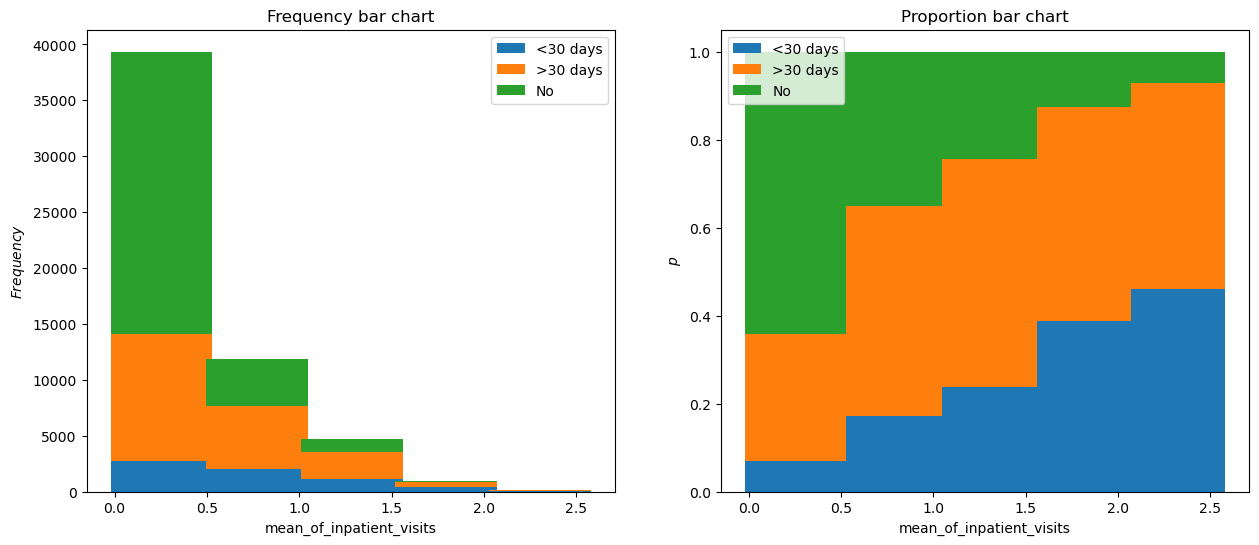

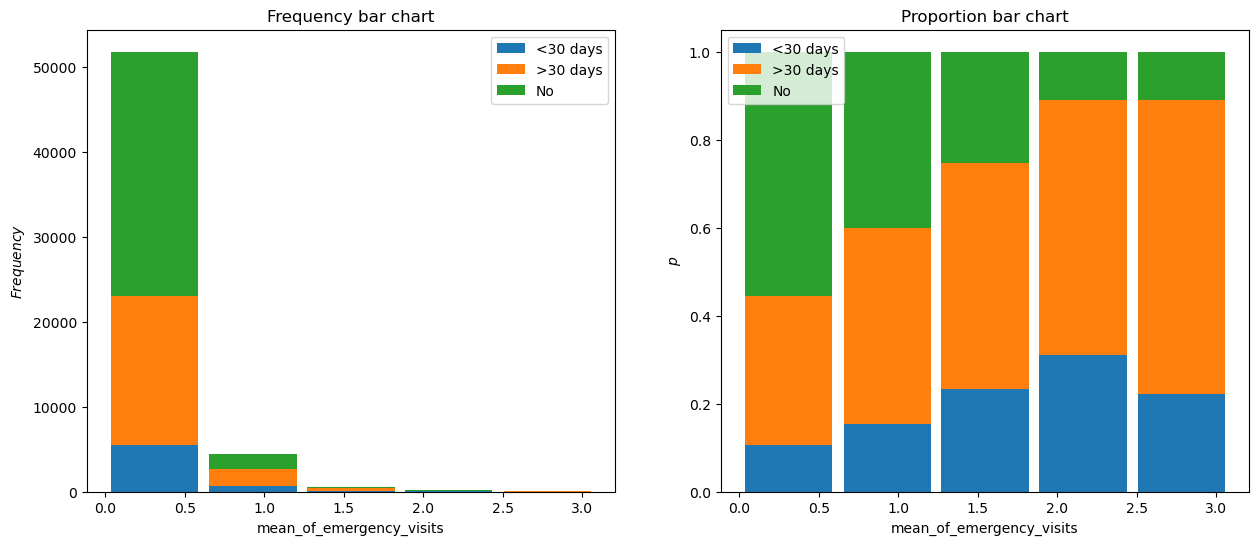

In [65]:
all_train = X_train.join(y_train)
bar_charts_numerical(all_train, 'mean_of_inpatient_visits', 'readmitted_multiclass', num_bins=5)
bar_charts_numerical(all_train, 'mean_of_emergency_visits', 'readmitted_multiclass', num_bins=5)

In [66]:
numerical_features = X_train.select_dtypes(include=np.number).columns
numerical_features

Index(['outpatient_visits_in_previous_year',
       'emergency_visits_in_previous_year',
       'inpatient_visits_in_previous_year', 'average_pulse_bpm',
       'length_of_stay_in_hospital', 'number_lab_tests', 'non_lab_procedures',
       'number_of_medications', 'number_diagnoses', 'medication_per_day',
       'lab_tests_per_day', 'patient_id', 'mean_of_inpatient_visits',
       'mean_of_emergency_visits'],
      dtype='object')

In [67]:
#same procedure for our validation data set
X_val['outpatient_visits_in_previous_year'] = np.log1p(X_val['outpatient_visits_in_previous_year'])
X_val['inpatient_visits_in_previous_year'] = np.log1p(X_val['inpatient_visits_in_previous_year'])
X_val['emergency_visits_in_previous_year'] = np.log1p(X_val['emergency_visits_in_previous_year'])


X_val.loc[X_val['emergency_visits_in_previous_year'] >= 3.2, 'emergency_visits_in_previous_year' ] = 0
X_val.loc[X_val['outpatient_visits_in_previous_year'] >= 3.2, 'outpatient_visits_in_previous_year' ] = 0

X_val.loc[X_val['length_of_stay_in_hospital']>12, 'length_of_stay_in_hospital'] = 4


X_val.loc[X_val['number_lab_tests']>96, 'number_lab_tests'] = 44

X_val.loc[X_val['number_of_medications']>34, 'number_of_medications'] = 15

X_val.loc[X_val['number_diagnoses']>13, 'number_diagnoses'] = 13

X_val.loc[X_val['non_lab_procedures']>5, 'non_lab_procedures'] = 5

X_val['medication_per_day'] = X_val['number_of_medications'] / X_val['length_of_stay_in_hospital']
X_val['lab_tests_per_day'] = X_val['number_lab_tests'] / X_val['length_of_stay_in_hospital']

#to ensure no data leakage we take the information if the nr_of_inpatient visits and do a left join on patient_id
X_val = pd.merge(X_val, X_train.groupby('patient_id')['mean_of_inpatient_visits'].max().reset_index(), on='patient_id', how='left').set_index(X_val_id)
X_val['mean_of_inpatient_visits'].fillna(X_val['inpatient_visits_in_previous_year'], inplace=True)

#same for emergency visits
X_val = pd.merge(X_val, X_train.groupby('patient_id')['mean_of_emergency_visits'].max().reset_index(), on='patient_id', how='left').set_index(X_val_id)
X_val['mean_of_emergency_visits'].fillna(X_val['emergency_visits_in_previous_year'], inplace=True)

X_train.drop(columns='patient_id', inplace=True)#drop patient id for val and train set since it's an id it's not worth keeping
X_val.drop(columns='patient_id', inplace=True)

numerical_features = X_train.select_dtypes(include=np.number).columns

Categoricals

In [68]:
categorical_features = X_train.select_dtypes(exclude=np.number).columns

In [69]:
#for now we fill NAs with 'NA' for the EDA
X_train[categorical_features] = X_train[categorical_features].fillna('NA')

In [70]:

    
def bar_charts_categorical(df, feature, target):
    cont_tab = pd.crosstab(df[feature], df[target], margins=True)
    categories = cont_tab.index[:-1]

    fig = plt.figure(figsize=(10, 4))

    # Frequency bar chart
    plt.subplot(121)
    bars = []
    bottom = np.zeros(len(categories))
    for i, class_label in enumerate(cont_tab.columns[:-1]):
        bars.append(plt.bar(categories, cont_tab.iloc[:-1, i].values, 0.55, bottom=bottom))
        bottom += cont_tab.iloc[:-1, i].values

    plt.legend([bar[0] for bar in bars], cont_tab.columns[:-1])
    plt.title("Frequency bar chart")
    plt.xlabel(feature)
    plt.ylabel("$Frequency$")

    # Proportion bar chart
    obs_pct = np.divide(cont_tab.iloc[:-1, :-1].values.T, cont_tab.iloc[:-1, -1].values).T

    plt.subplot(122)
    bars = []
    bottom = np.zeros(len(categories))
    for i, class_label in enumerate(cont_tab.columns[:-1]):
        bars.append(plt.bar(categories, obs_pct[:, i], 0.55, bottom=bottom))
        bottom += obs_pct[:, i]

    plt.legend([bar[0] for bar in bars], cont_tab.columns[:-1])
    plt.title("Proportion bar chart")
    plt.xlabel(feature)
    plt.ylabel("$p$")
    plt.xticks(rotation=45)

    plt.show()

country
USA    56988
Name: count, dtype: int64


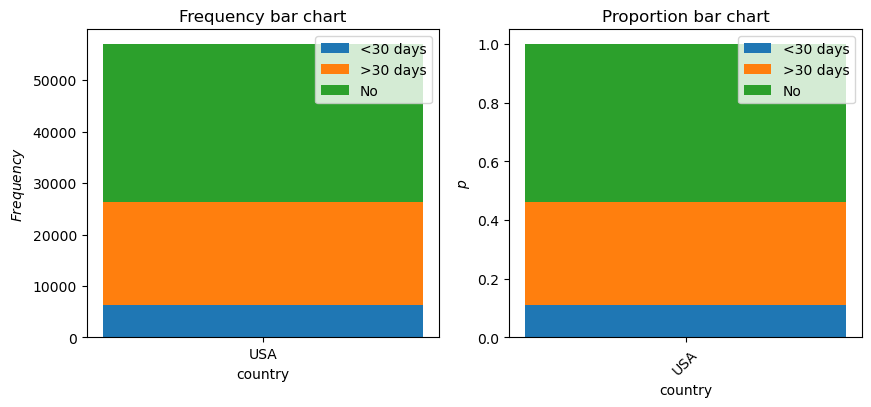

race
Caucasian          40500
AfricanAmerican    10185
NA                  2846
?                   1226
Hispanic            1084
Other                800
Asian                347
Name: count, dtype: int64


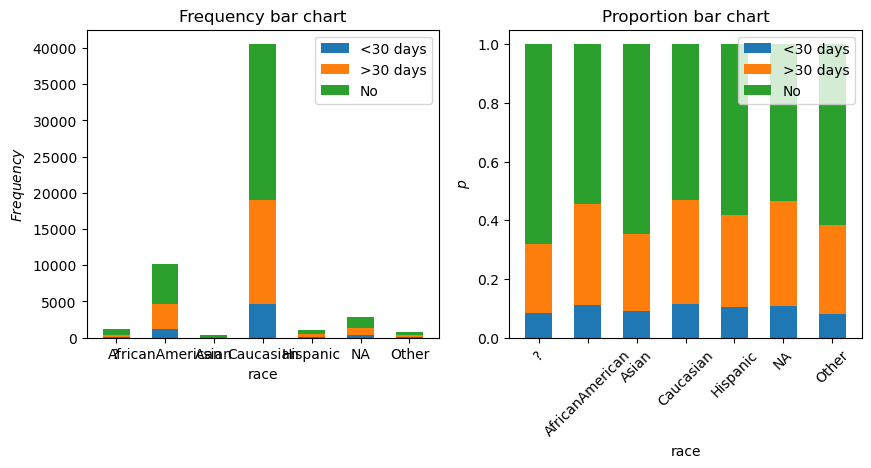

gender
Female             30531
Male               26454
Unknown/Invalid        3
Name: count, dtype: int64


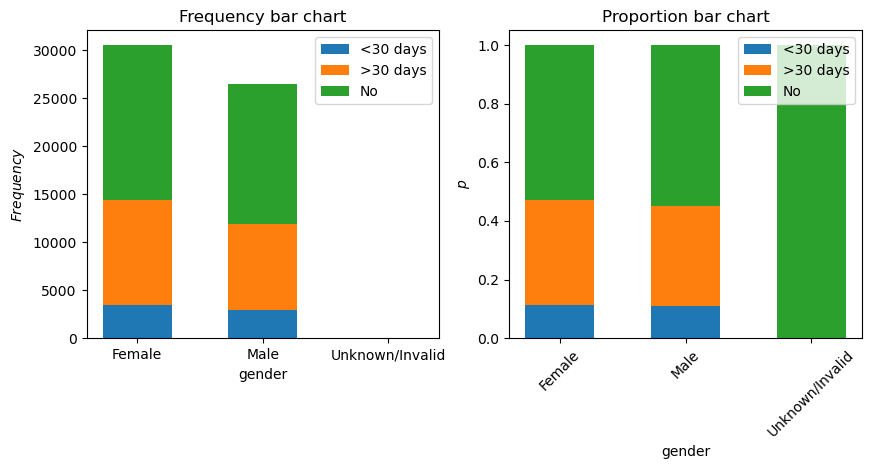

age
[70-80)     13879
[60-70)     11931
[80-90)      9230
[50-60)      9091
[40-50)      5173
NA           2835
[30-40)      2041
[90-100)     1491
[20-30)       852
[10-20)       385
[0-10)         80
Name: count, dtype: int64


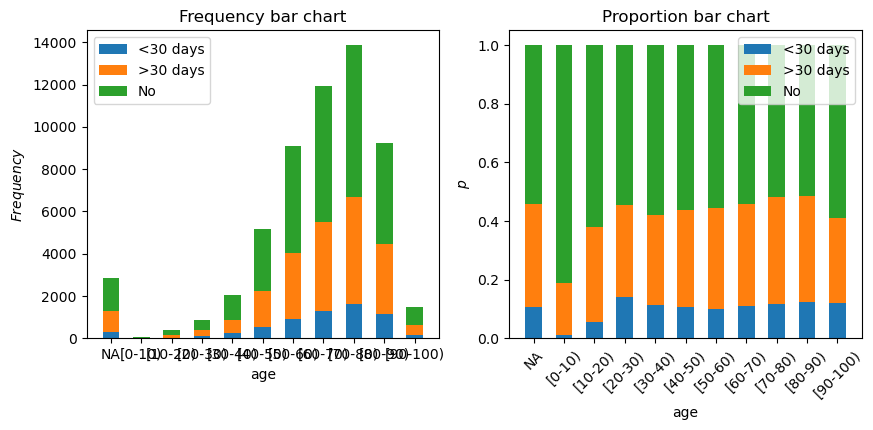

weight
?            55191
[75-100)       733
[50-75)        509
[100-125)      373
[125-150)       77
[25-50)         53
[0-25)          29
[150-175)       16
[175-200)        6
>200             1
Name: count, dtype: int64


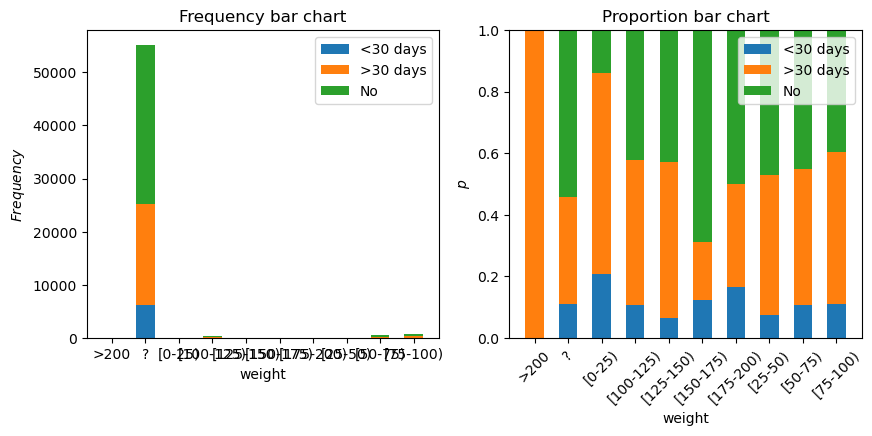

payer_code
?     22520
MC    18089
HM     3499
SP     2815
BC     2649
MD     1981
CP     1421
UN     1410
CM     1090
OG      580
PO      335
DM      317
WC       81
CH       79
OT       43
MP       41
SI       37
FR        1
Name: count, dtype: int64


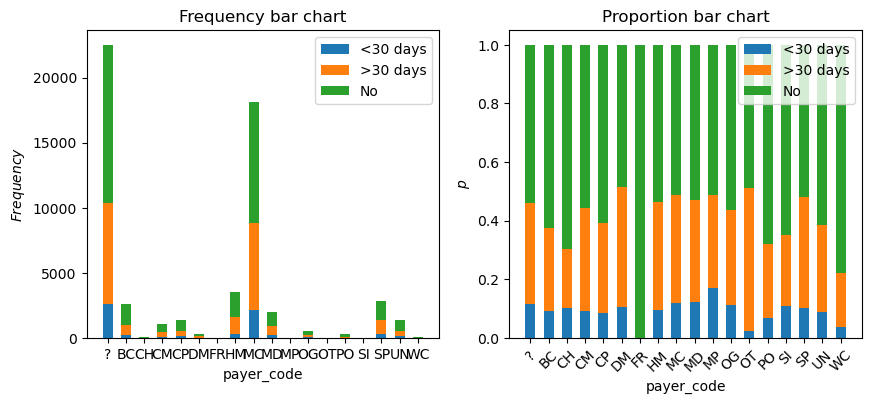

admission_type
Emergency        30235
Urgent           10489
Elective         10432
NA                2987
Not Available     2648
Not Mapped         179
Trauma Center       12
Newborn              6
Name: count, dtype: int64


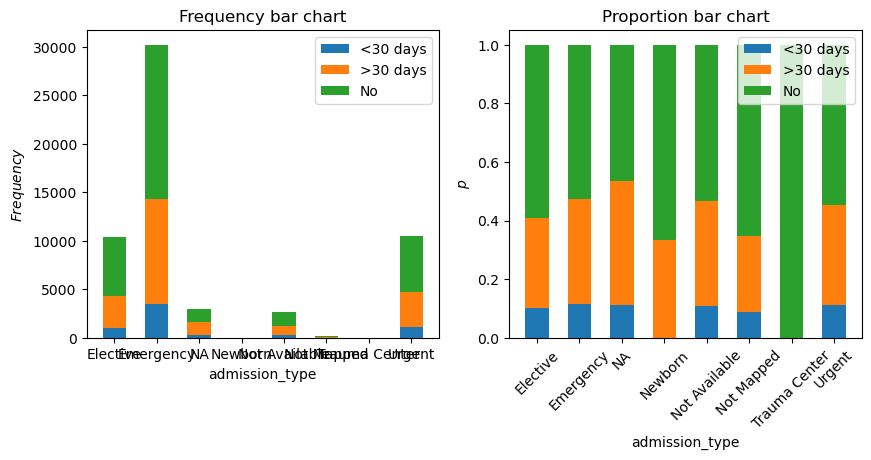

medical_specialty
?                                27783
InternalMedicine                  8304
Emergency/Trauma                  4255
Family/GeneralPractice            4202
Cardiology                        3005
                                 ...  
Pediatrics-InfectiousDiseases        1
Neurophysiology                      1
Resident                             1
Proctology                           1
SportsMedicine                       1
Name: count, Length: 66, dtype: int64


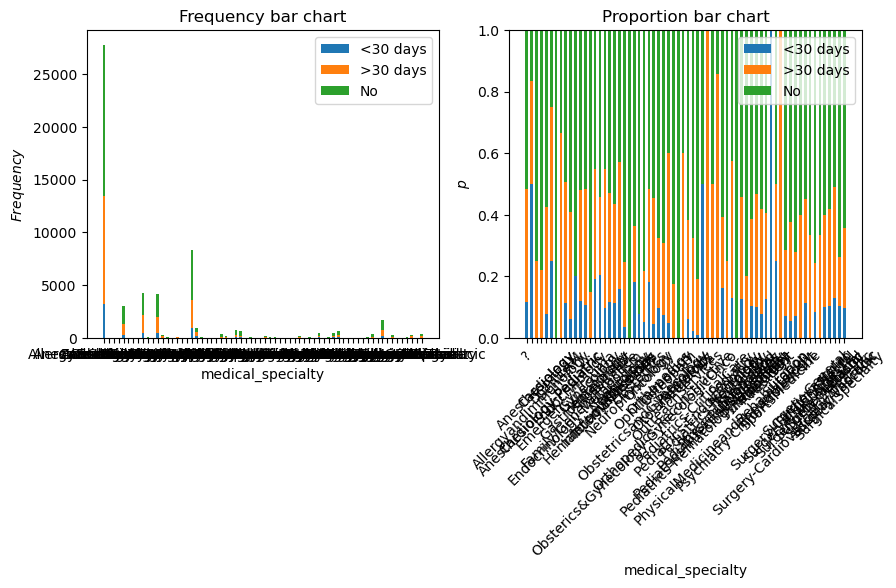

discharge_disposition
Discharged to home                                                                                           33738
Discharged/transferred to SNF                                                                                 7781
Discharged/transferred to home with home health service                                                       7283
NA                                                                                                            2084
Discharged/transferred to another short term hospital                                                         1201
Discharged/transferred to another rehab fac including rehab units of a hospital .                             1108
Expired                                                                                                        903
Discharged/transferred to another type of inpatient care institution                                           651
Not Mapped                                                

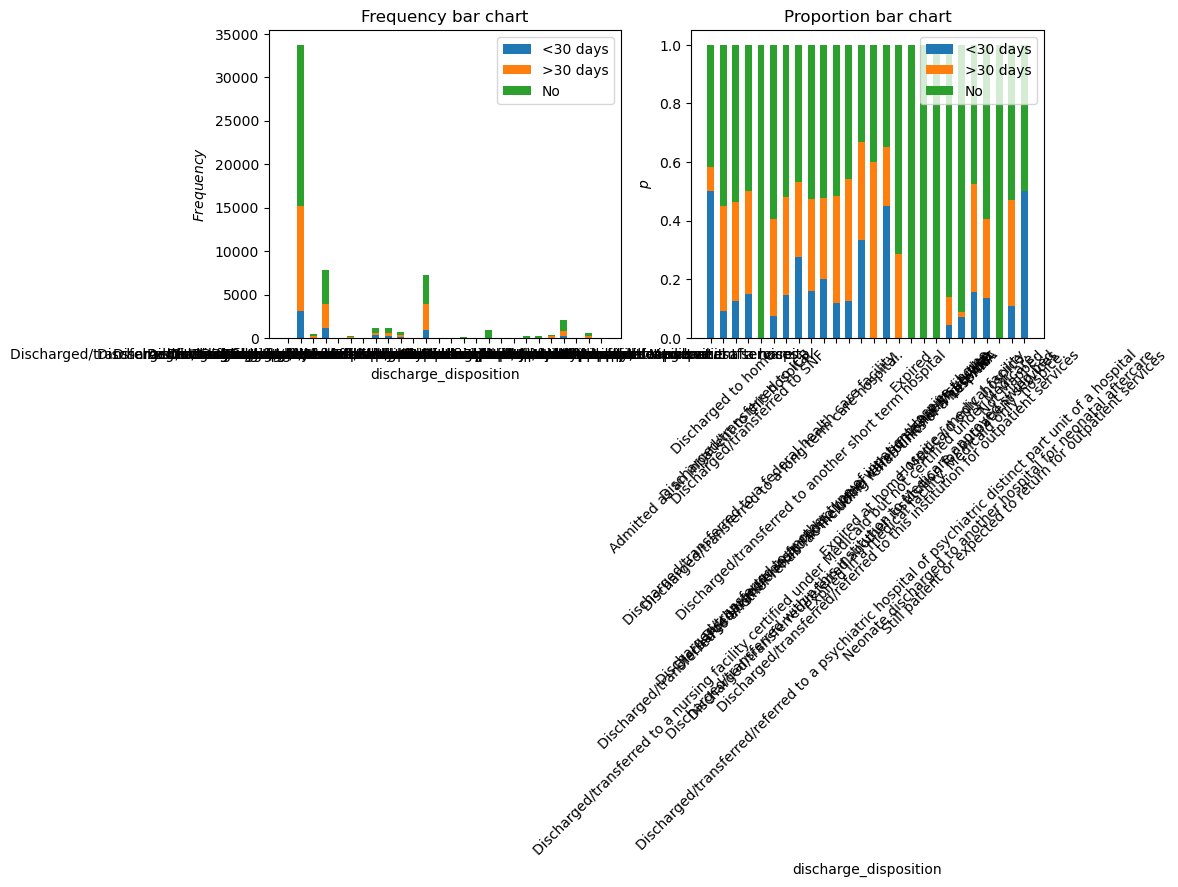

admission_source
 Emergency Room                                               32300
 Physician Referral                                           16508
NA                                                             3775
Transfer from a hospital                                       1806
 Transfer from another health care facility                    1242
Clinic Referral                                                 612
 Transfer from a Skilled Nursing Facility (SNF)                 464
HMO Referral                                                    103
 Not Mapped                                                      81
 Not Available                                                   73
 Court/Law Enforcement                                            8
 Transfer from critial access hospital                            7
 Transfer from hospital inpt/same fac reslt in a sep claim        5
 Extramural Birth                                                 1
 Sick Baby                     

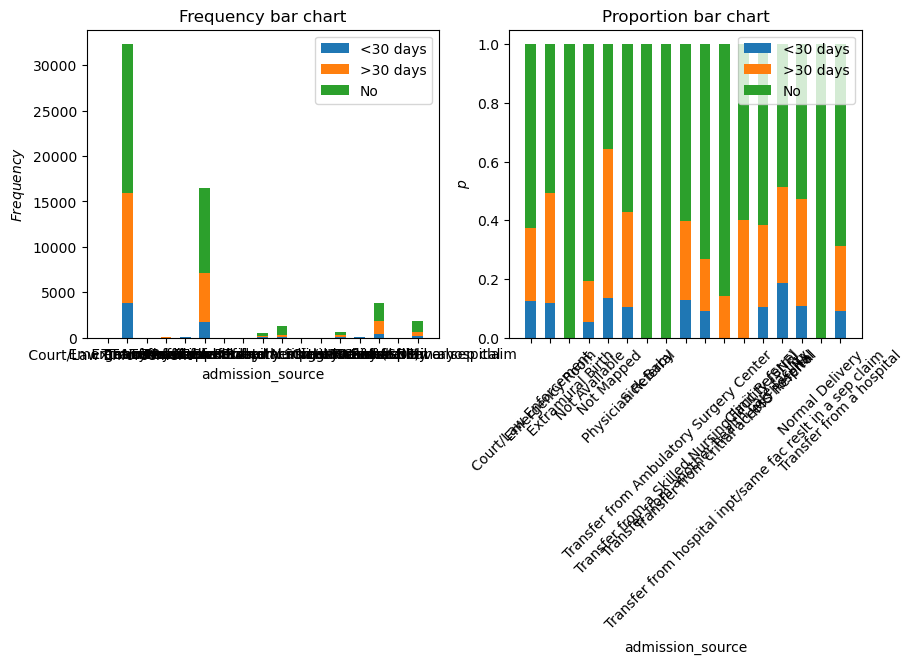

primary_diagnosis
428    3808
414    3651
786    2286
410    2027
486    1990
       ... 
640       1
147       1
880       1
523       1
685       1
Name: count, Length: 658, dtype: int64


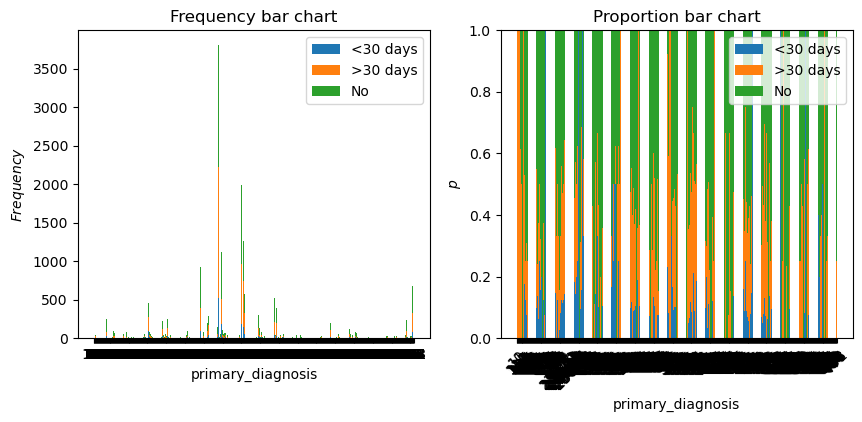

secondary_diagnosis
276    3791
428    3751
250    3411
427    2843
401    2095
       ... 
977       1
810       1
814       1
318       1
164       1
Name: count, Length: 675, dtype: int64


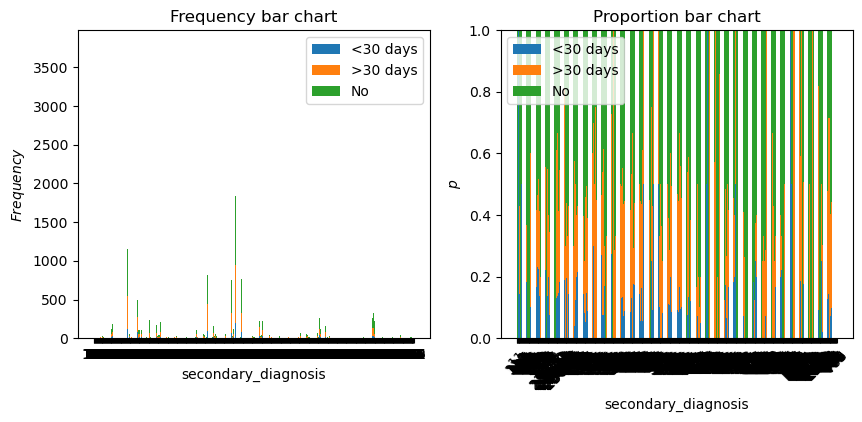

additional_diagnosis
250    6397
401    4624
276    2907
428    2595
427    2214
       ... 
911       1
115       1
821       1
877       1
852       1
Name: count, Length: 716, dtype: int64


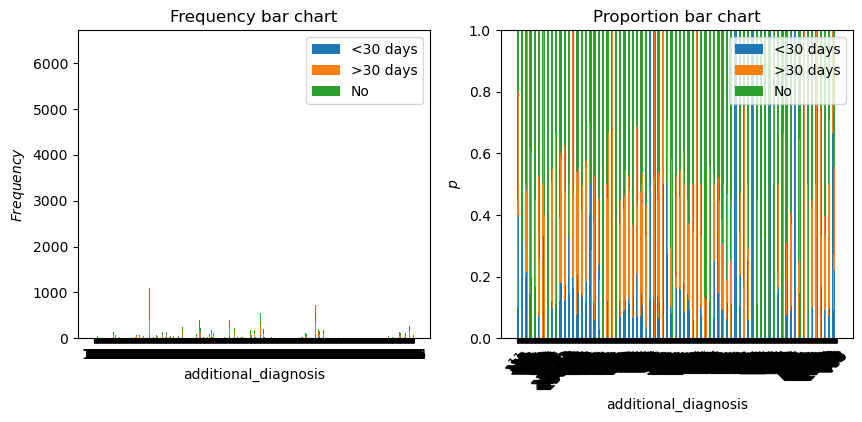

glucose_test_result
NA      54014
Norm     1469
>200      846
>300      659
Name: count, dtype: int64


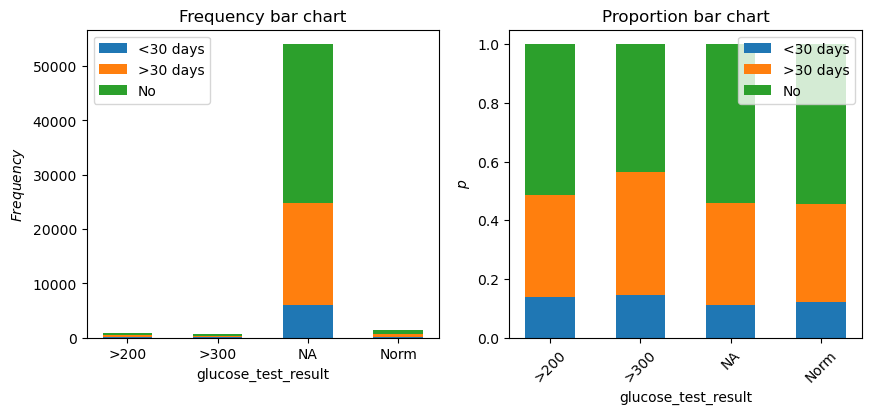

a1c_test_result
NA      47447
>8       4564
Norm     2792
>7       2185
Name: count, dtype: int64


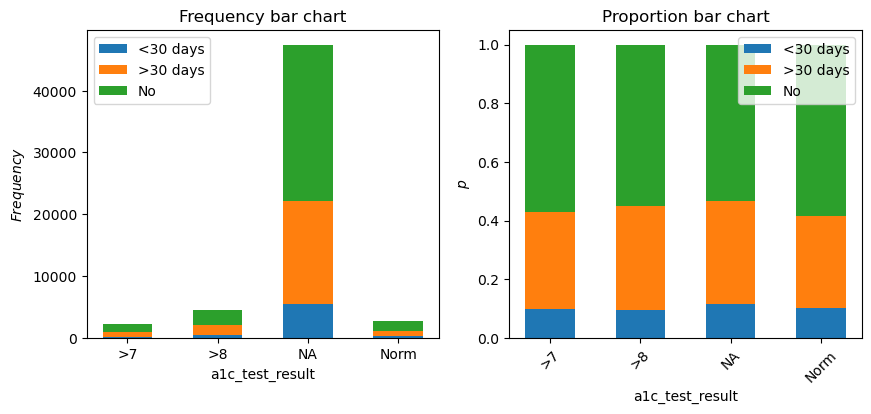

change_in_meds_during_hospitalization
No    30596
Ch    26392
Name: count, dtype: int64


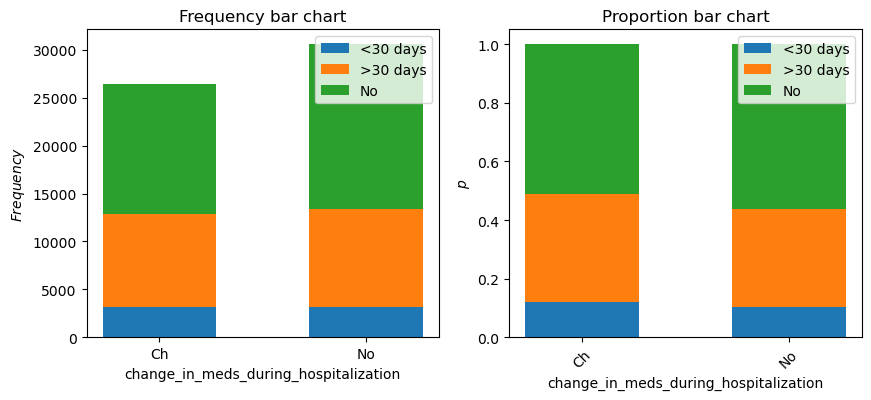

prescribed_diabetes_meds
Yes    43870
No     13118
Name: count, dtype: int64


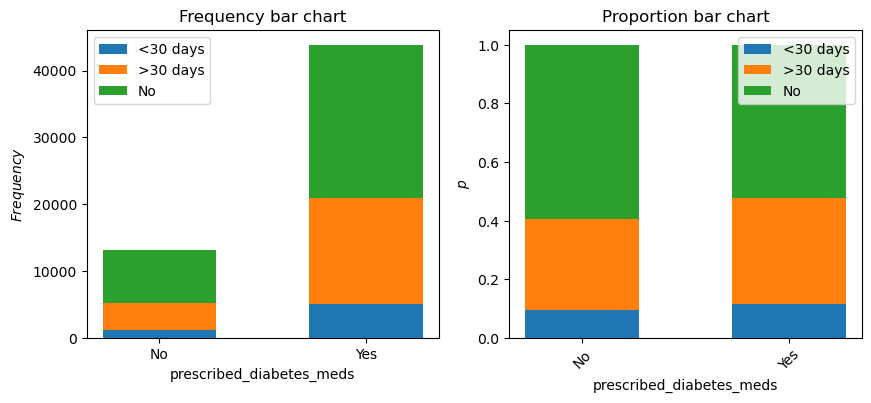

medication
['insulin']                                              17373
[]                                                       13118
['metformin']                                             2513
['metformin', 'insulin']                                  2424
['glipizide']                                             2166
                                                         ...  
['glipizide', 'pioglitazone', 'acarbose', 'insulin']         1
['acetohexamide', 'insulin']                                 1
['repaglinide', 'glyburide', 'pioglitazone']                 1
['glimepiride', 'rosiglitazone', 'acarbose']                 1
['metformin', 'rosiglitazone', 'acarbose', 'insulin']        1
Name: count, Length: 280, dtype: int64


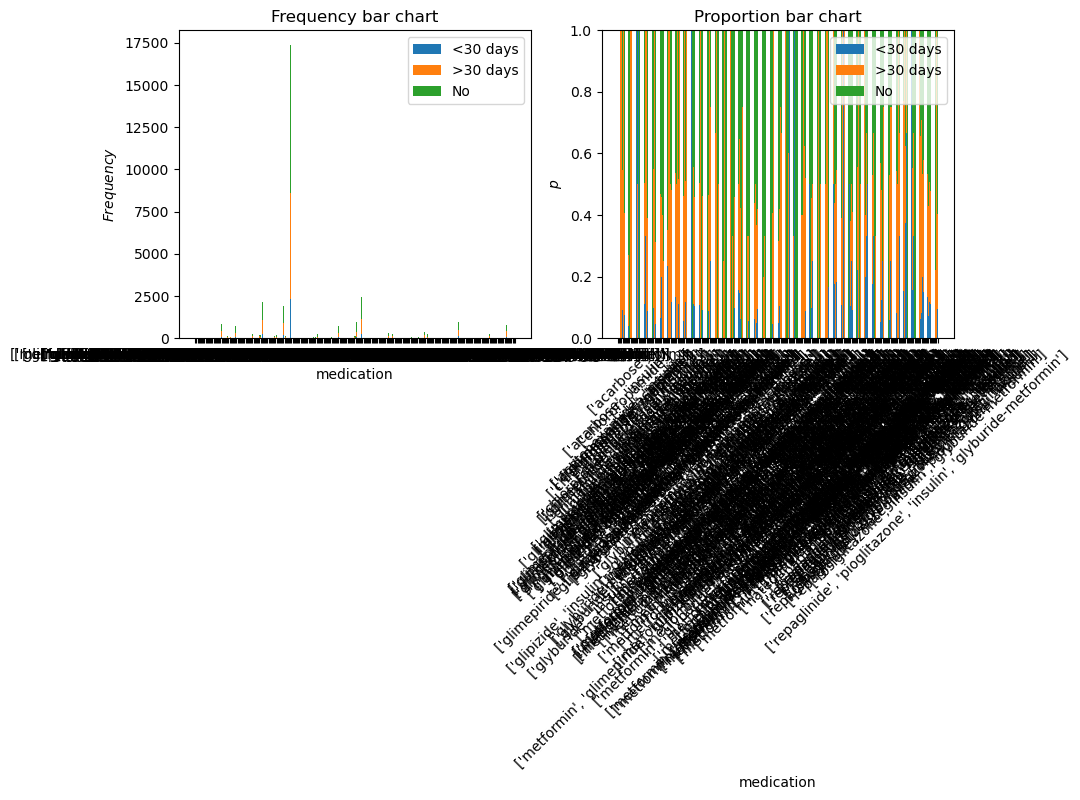

binary_prediction
No     41114
Yes    15874
Name: count, dtype: int64


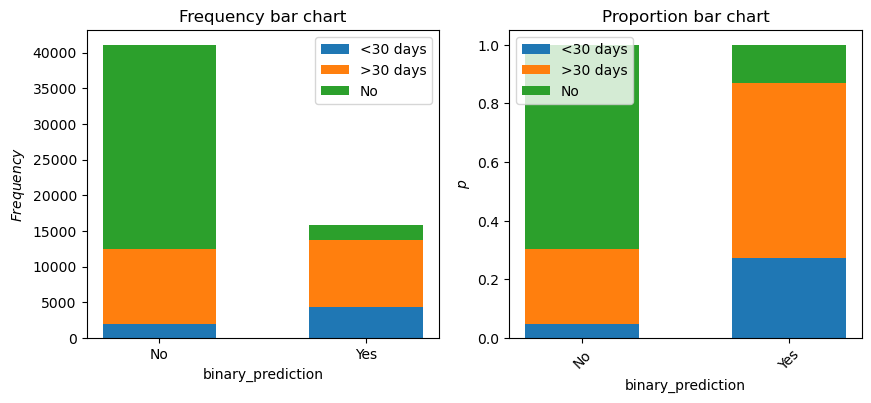

In [71]:
all_train = X_train.join(y_train)
for col in categorical_features:
    print(X_train[col].value_counts())    
    bar_charts_categorical(all_train, col, "readmitted_multiclass")


Categorical Preprocessing

In [72]:
#country
X_train.drop(columns='country', inplace=True)

#race
X_train.loc[X_train['race']=='NA', 'race'] = '?'

#gender
X_train.loc[X_train['gender']=='Unknown/Invalid', 'gender'] = 'Female'

#age
X_train.loc[X_train['age']=='NA', 'age'] = '[70-80)'

#weight
other = ['[125-150)', '[25-50)', '[0-25)', '[150-175)', '[175-200)', '>200 ']
X_train['weight'] = X_train['weight'].replace(other, 'other')

#payercode
other = ['CH', 'WC', 'OT', 'MP', 'SI', 'FR']
X_train['payer_code'] = X_train['payer_code'].replace(other, 'other')


#admission_type
X_train.loc[X_train['admission_type']=='NA', 'admission_type'] = 'Not Mapped'
other = ['Not Mapped', 'Trauma Center', 'Newborn']
X_train['admission_type'] = X_train['admission_type'].replace(other, 'other')


#discharge_disposition
X_train.loc[X_train['discharge_disposition']=='NA', 'discharge_disposition'] = 'Not Mapped'
category_counts = X_train['discharge_disposition'].value_counts()
other_discharge= category_counts[category_counts < X_train.shape[0] * 0.005].index
X_train['discharge_disposition'] = X_train['discharge_disposition'].replace(other_discharge, 'other')

#medical_specialty
X_train.loc[X_train['medical_specialty']=='NA', 'medical_specialty'] = 'Not Mapped'
category_counts = X_train['medical_specialty'].value_counts()
other_medical_specialty = category_counts[category_counts < X_train.shape[0] * 0.005].index
X_train['medical_specialty'] = X_train['medical_specialty'].replace(other_medical_specialty , 'other')


#admission_source
X_train.loc[X_train['admission_source']=='NA', 'admission_source'] = 'Not Mapped'
X_train.loc[X_train['admission_source']=='Not Available', 'admission_source'] = 'Not Mapped'

other= ['HMO Referral', 'Court/Law Enforcement', 'Transfer from hospital inpt/same fac reslt in a sep claim', 'Transfer from critial access hospital', 'Transfer from Ambulatory Surgery Center', 'Extramural Birth', 'Normal Delivery', 'Sick Baby']
X_train['admission_source'] = X_train['admission_source'].replace(other, 'other')

#medication
category_counts = X_train['medication'].value_counts()
other_med = category_counts[category_counts < X_train.shape[0] * 0.005].index
X_train['medication'] = X_train['medication'].replace(other_med, 'other')

In [73]:
#for the diagnosis, since it's too many categories, aggregate the icd 9 codes regarding there icd 9 class to aggregate the categories
#this way we have more stable frequencies, but maybe loose some information threw aggregation, but we take the tradeoff

icd9_mapping = {
    'Infectious and Parasitic Diseases': (1, 139),
    'Neoplasms': (140, 239),
    'Endocrine, Nutritional, Metabolic Diseases, and Immunity Disorders': (240, 279),
    'Diseases of the Blood and Blood-Forming Organs': (280, 289),
    'Mental Disorders': (290, 319),
    'Diseases of the Nervous System and Sense Organs': (320, 389),
    'Diseases of the Circulatory System': (390, 459),
    'Diseases of the Respiratory System': (460, 519),
    'Diseases of the Digestive System': (520, 579),
    'Diseases of the Genitourinary System': (580, 629),
    'Complications of Pregnancy, Childbirth, and the Puerperium': (630, 679),
    'Diseases of the Skin and Subcutaneous Tissue': (680, 709),
    'Diseases of the Musculoskeletal System and Connective Tissue': (710, 739),
    'Congenital Anomalies': (740, 759),
    'Certain Conditions Originating in the Perinatal Period': (760, 779),
    'Symptoms, Signs, and Ill-Defined Conditions': (780, 799),
    'Injury and Poisoning': (800, 999),
    'External Causes of Injury': ('E',),
    'Supplemental Classification': ('V',)
}

def map_icd9_code(icd9_code, icd9_mapping):
    # Check for 'E' and 'V' codes
    if icd9_code.startswith('E'):
        return 'External Causes of Injury'
    
    if icd9_code.startswith('V'):
        return 'Supplemental Classification'
    
    if '250' in icd9_code: #since we know diabetes is important for hospital readmission we encode them seperately
        return 'Diabetes'
    
    for category, code_range in icd9_mapping.items():
        if icd9_code.isdigit():
            start, end = code_range
            if start <= int(icd9_code) <= end:
                return category
    
    if icd9_code == '?':
        return icd9_code
    
    return 'other'

In [74]:
X_train['primary_icd9_class'] = X_train['primary_diagnosis'].apply(lambda x: map_icd9_code(x, icd9_mapping))
X_train['secondary_icd9_class'] = X_train['secondary_diagnosis'].apply(lambda x: map_icd9_code(x, icd9_mapping))
X_train['additional_icd9_class'] = X_train['additional_diagnosis'].apply(lambda x: map_icd9_code(x, icd9_mapping))

X_train.drop(columns = ['primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis'], inplace=True)

primary_icd9_class
Diseases of the Circulatory System                                    16982
Diseases of the Respiratory System                                     5812
Diseases of the Digestive System                                       5171
Diabetes                                                               4907
Symptoms, Signs, and Ill-Defined Conditions                            4312
Injury and Poisoning                                                   3891
Diseases of the Genitourinary System                                   2858
Diseases of the Musculoskeletal System and Connective Tissue           2738
Neoplasms                                                              1952
Infectious and Parasitic Diseases                                      1541
Endocrine, Nutritional, Metabolic Diseases, and Immunity Disorders     1507
Diseases of the Skin and Subcutaneous Tissue                           1407
Mental Disorders                                                     

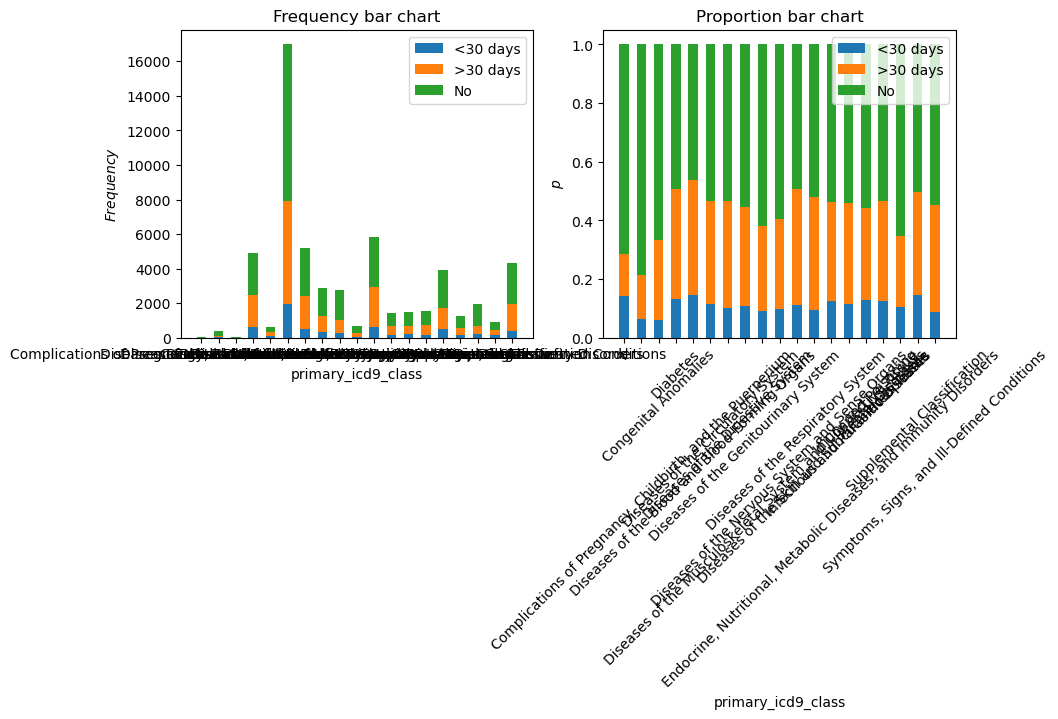

secondary_icd9_class
Diseases of the Circulatory System                                    17579
Diabetes                                                               7186
Diseases of the Respiratory System                                     5754
Endocrine, Nutritional, Metabolic Diseases, and Immunity Disorders     4630
Diseases of the Genitourinary System                                   4490
Symptoms, Signs, and Ill-Defined Conditions                            2499
Diseases of the Digestive System                                       2190
Diseases of the Skin and Subcutaneous Tissue                           2055
Diseases of the Blood and Blood-Forming Organs                         1635
Mental Disorders                                                       1451
Neoplasms                                                              1423
Injury and Poisoning                                                   1370
Infectious and Parasitic Diseases                                  

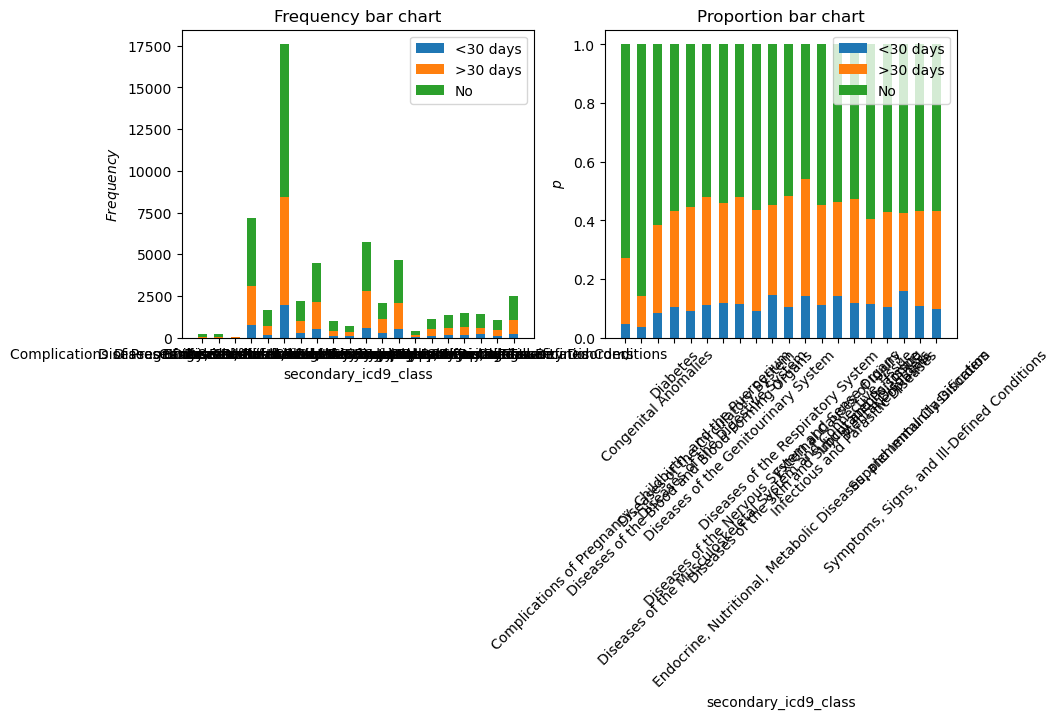

additional_icd9_class
Diseases of the Circulatory System                                    16799
Diabetes                                                               9471
Endocrine, Nutritional, Metabolic Diseases, and Immunity Disorders     5115
Diseases of the Respiratory System                                     3800
Diseases of the Genitourinary System                                   3552
Symptoms, Signs, and Ill-Defined Conditions                            2502
Supplemental Classification                                            2115
Diseases of the Digestive System                                       2027
Mental Disorders                                                       1792
Diseases of the Skin and Subcutaneous Tissue                           1420
Diseases of the Blood and Blood-Forming Organs                         1406
Injury and Poisoning                                                   1094
Diseases of the Musculoskeletal System and Connective Tissue      

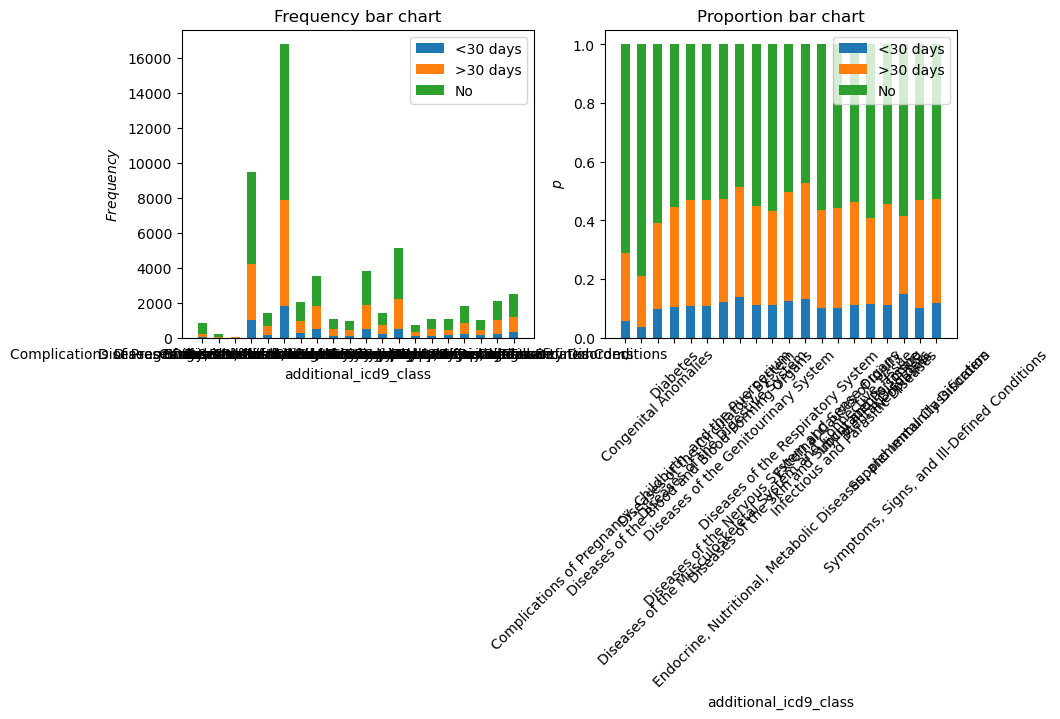

In [75]:
all_train = X_train.join(y_train)
for col in ['primary_icd9_class', 'secondary_icd9_class', 'additional_icd9_class']:
    print(all_train[col].value_counts())    
    bar_charts_categorical(all_train, col, "readmitted_multiclass")

In [76]:
#we decide to do frequency encoding for every feature with a number of categories >2, otherwise we use one hot encoding
#this way we keep our input space very small and avoid a sparse dataset, also we can include the features in the Feature Selection process with the
#numerical features without risking too long runtimes
#a disadvantage of this encoding tecnique might be a loss of information in comparison to one hot encoding every variable

categorical_features = X_train.select_dtypes(exclude=np.number).columns
binary_encoding_columns = ['gender', 'change_in_meds_during_hospitalization', 'prescribed_diabetes_meds', 'binary_prediction']
frequency_encoding_columns = list(set(categorical_features)-set(binary_encoding_columns))

In [77]:
X_train['gender'] = X_train['gender'].replace({'Female':1, 'Male':0})
X_train['change_in_meds_during_hospitalization'] = X_train['change_in_meds_during_hospitalization'].replace({'Ch':1, 'No':0})
X_train['prescribed_diabetes_meds'] = X_train['prescribed_diabetes_meds'].replace({'Yes':1, 'No':0})

#binary prediction
X_train['binary_prediction'] = X_train['binary_prediction'].replace({'Yes':1, 'No':0})

In [78]:
#preprocessing for validation set

#NAs beginning
categorical_features = X_val.select_dtypes(exclude=np.number).columns
X_val[categorical_features] = X_val[categorical_features].fillna('NA')

#country
X_val.drop(columns='country', inplace=True)

#race
X_val.loc[X_val['race']=='NA', 'race'] = '?'

#gender
X_val.loc[X_val['gender']=='Unknown/Invalid', 'gender'] = 'Female'

#age
X_val.loc[X_val['age']=='NA', 'age'] = '[70-80)'

#weight
other = ['[125-150)', '[25-50)', '[0-25)', '[150-175)', '[175-200)', '>200 ']
X_val['weight'] = X_val['weight'].replace(other, 'other')

#payercode
other = ['CH', 'WC', 'OT', 'MP', 'SI', 'FR']
X_val['payer_code'] = X_val['payer_code'].replace(other, 'other')

#admission_type
X_val.loc[X_val['admission_type']=='NA', 'admission_type'] = 'Not Mapped'
other = ['Not Mapped', 'Trauma Center', 'Newborn']
X_val['admission_type'] = X_val['admission_type'].replace(other, 'other')

#discharge disposition
X_val.loc[X_val['discharge_disposition']=='NA', 'discharge_disposition'] = 'Not Mapped'
X_val['discharge_disposition'] = X_val['discharge_disposition'].replace(other_discharge, 'other')

#medical specialty
X_val['medical_specialty'] = X_val['medical_specialty'].replace(other_medical_specialty, 'other')

#admission_source
X_val.loc[X_val['admission_source']=='NA', 'admission_source'] = 'Not Mapped'
X_val.loc[X_val['admission_source']=='Not Available', 'admission_source'] = 'Not Mapped'
other= ['HMO Referral', 'Court/Law Enforcement', 'Transfer from hospital inpt/same fac reslt in a sep claim', 'Transfer from critial access hospital', 'Transfer from Ambulatory Surgery Center', 'Extramural Birth', 'Normal Delivery', 'Sick Baby']
X_val['admission_source'] = X_val['admission_source'].replace(other, 'other')

#medication
X_val['medication'] = X_val['medication'].replace(other_med, 'other')

In [79]:
X_val['primary_icd9_class'] = X_val['primary_diagnosis'].apply(lambda x: map_icd9_code(x, icd9_mapping))
X_val['secondary_icd9_class'] = X_val['secondary_diagnosis'].apply(lambda x: map_icd9_code(x, icd9_mapping))
X_val['additional_icd9_class'] = X_val['additional_diagnosis'].apply(lambda x: map_icd9_code(x, icd9_mapping))

X_val.drop(columns = ['primary_diagnosis', 'secondary_diagnosis', 'additional_diagnosis'], inplace=True)

In [80]:
X_val['gender'] = X_val['gender'].replace({'Female':1, 'Male':0})
X_val['change_in_meds_during_hospitalization'] = X_val['change_in_meds_during_hospitalization'].replace({'Ch':1, 'No':0})
X_val['prescribed_diabetes_meds'] = X_val['prescribed_diabetes_meds'].replace({'Yes':1, 'No':0})
X_val['binary_prediction'] = X_val['binary_prediction'].replace({'Yes':1, 'No':0})

In [81]:
#frequency encoding for X_train and X_val together since we use the frequencies from the training set to avoid data leakage
def frequency_encode_columns(df1, df2, columns):
    frequency_mappings = {}
    
    for column in columns:
        frequency_mapping = df1[column].value_counts(normalize=True)
        frequency_mappings[column] = frequency_mapping
    
    for column, mapping in frequency_mappings.items():
        df1[column] = df1[column].map(mapping)
        df2[column] = df2[column].map(mapping).fillna(0)  # Fill NaN with 0 for unseen categories in validation set
    
    return df1, df2


X_train, X_val = frequency_encode_columns(X_train, X_val, columns=frequency_encoding_columns)

Preprocessing together

In [82]:
#scale the numerical and frequencie endoed features
features_to_scale = list(list(frequency_encoding_columns) + list(numerical_features))

In [83]:
scaler = StandardScaler()

#we use as standardscaler since most of our distribution are skewed and standard scalers are less affected by outliers in the absence of normal distribution
scaler.fit(X_train[features_to_scale])

X_train_num_scaled = scaler.transform(X_train[features_to_scale])
X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = X_train[features_to_scale].columns).set_index(X_train.index)

X_val_num_scaled = scaler.transform(X_val[features_to_scale])
X_val_num_scaled = pd.DataFrame(X_val_num_scaled, columns = X_val[features_to_scale].columns).set_index(X_val.index)

X_train = pd.concat([X_train_num_scaled, X_train[binary_encoding_columns]], axis=1)
X_val =  pd.concat([X_val_num_scaled, X_val[binary_encoding_columns]], axis=1)


In [84]:
y_train = y_train.replace({'No': 0, '>30 days': 1, '<30 days':2})
y_val = y_val.replace({'No': 0, '>30 days': 1, '<30 days':2})

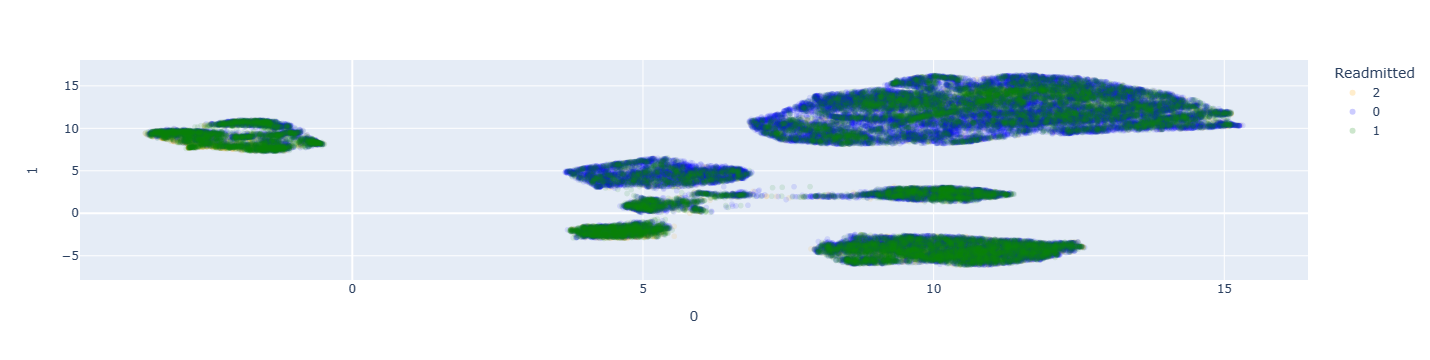

In [85]:
#try a visualization with umap to see if there are clear decision boundaries visible
#clearly there are none, but u can spot areas in the middle left and upper right where 
umap_2d = UMAP(n_components=2, random_state=0)
proj_2d = umap_2d.fit_transform(X_train_num_scaled[numerical_features])
fig = px.scatter(proj_2d, x=0, y=1, color=y_train.astype(str), opacity=0.1,
                 color_discrete_map={'1': 'green', '0': 'blue', '2':'orange'},
                 labels={'color': 'Readmitted'})
fig.show()

Feature Selection Categorical

In [86]:
Feature_selection = pd.DataFrame(index=X_train.columns)

In [87]:
#General Idea: we use 5 Feature Selection methods and decide which features to keep by majority vote, for multiclass 3 only since we cant use the anova

In [88]:
#LassoCV

In [89]:
#also we use lasso cv to see which variables the l1 regularization would exclude / set parameters to 0
reg = LassoCV()
reg.fit(X_train, y_train)
coef = pd.Series(reg.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
coef

Lasso picked 30 variables and eliminated the other 1 variables


discharge_disposition                    0.006883
secondary_icd9_class                     0.007682
admission_type                          -0.026836
medication                               0.000447
medical_specialty                        0.017113
race                                     0.012280
admission_source                         0.031693
additional_icd9_class                   -0.000000
glucose_test_result                     -0.002517
weight                                  -0.031956
a1c_test_result                          0.004851
age                                      0.006328
payer_code                               0.030695
primary_icd9_class                       0.008506
outpatient_visits_in_previous_year       0.019331
emergency_visits_in_previous_year        0.012309
inpatient_visits_in_previous_year       -0.101520
average_pulse_bpm                        0.000752
length_of_stay_in_hospital              -0.001692
number_lab_tests                         0.000295


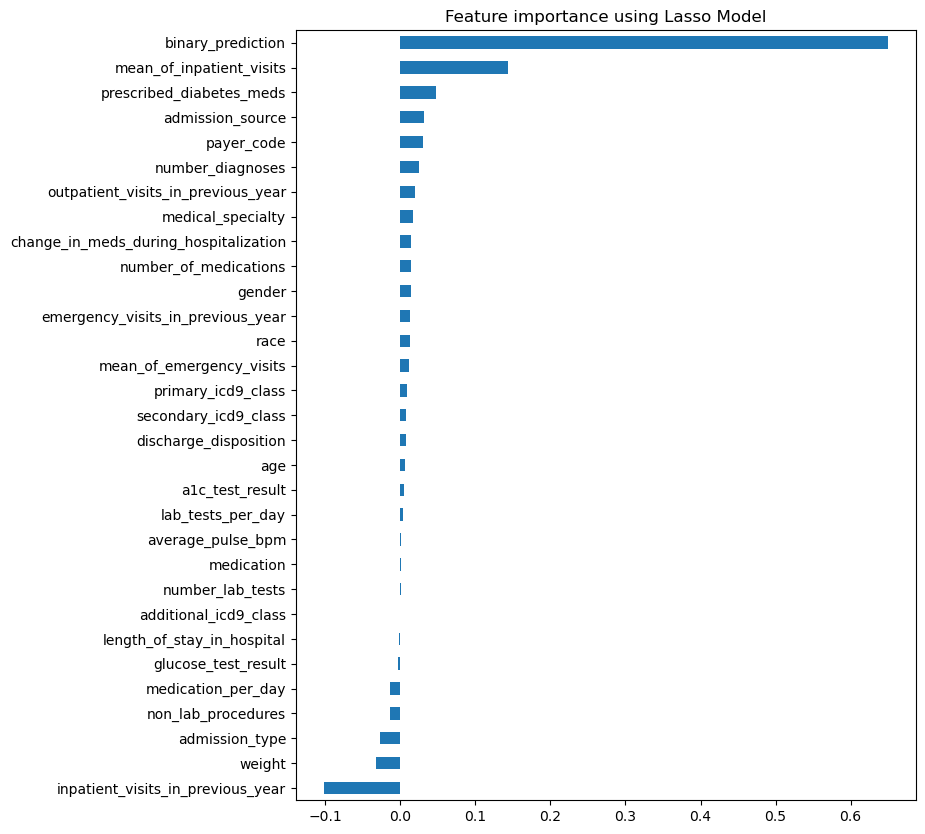

In [90]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()
plot_importance(coef,'Lasso')

In [91]:
feature_selection = pd.DataFrame({'Feature': X_train.columns, 'Lasso_cv': coef})
feature_selection.set_index('Feature', inplace=True)
feature_selection.sort_values(by='Lasso_cv', ascending=False, inplace=True)

In [92]:
feature_selection['Lasso_cv_>_0'] = (feature_selection['Lasso_cv'].abs() > 0.0001).astype(int)
feature_selection['sum'] = feature_selection['Lasso_cv_>_0']
feature_selection

Lasso_cv  Lasso_cv_>_0  sum
Feature                                                           
binary_prediction                      0.649545             1    1
mean_of_inpatient_visits               0.143080             1    1
prescribed_diabetes_meds               0.047371             1    1
admission_source                       0.031693             1    1
payer_code                             0.030695             1    1
number_diagnoses                       0.024303             1    1
outpatient_visits_in_previous_year     0.019331             1    1
medical_specialty                      0.017113             1    1
change_in_meds_during_hospitalization  0.014609             1    1
number_of_medications                  0.013999             1    1
gender                                 0.013750             1    1
emergency_visits_in_previous_year      0.012309             1    1
race                                   0.012280             1    1
mean_of_emergency_visits               0.011264             1    1
primary_icd9_class                     0.008506             1    1
secondary_icd9_class                   0.007682             1    1
discharge_disposition                  0.006883             1    1
age                                    0.006328             1    1
a1c_test_result                        0.004851             1    1
lab_tests_per_day                      0.003567             1    1
average_pulse_bpm                      0.000752             1    1
medication                             0.000447             1    1
number_lab_tests                       0.000295             1    1
additional_icd9_class                 -0.000000             0    0
length_of_stay_in_hospital            -0.001692             1    1
glucose_test_result                   -0.002517             1    1
medication_per_day                    -0.013637             1    1
non_lab_procedures                    -0.014305             1    1
admission_type                        -0.026836             1    1
weight                                -0.031956             1    1
inpatient_visits_in_previous_year     -0.101520             1    1

In [93]:
#RFE Logreg

In [94]:
#now we are using two recursive feature elimination models
#we start with a logistic regression, followed by a decision tree
#the logistic regression is supposed to represent the distance based, the decision tree to represent the tree based methods in the majority vote

#we give a parameter grid to the for loop in which we first do a cross grid search for each number of features to get appropriate parameters
#then we get the cross validation scores for each number of features and compare them
#we dont use the validation set to avoid data leakage

In [95]:
param_grid = {
    'solver': ['lbfgs','saga', 'newton-cg','sag'],
    'penalty': ['l2'],
    'C': [0.5, 1, 2]
}
#we choose l2 regularization cause l1 regularization is already involved in the lasso cv

# Variables to store results
avg_val_scores = []
best_params_list = []
min = 1

for n in range(min, len(X_train.columns) + 1):
    model = LogisticRegression(random_state=0, class_weight='balanced')

    rfe = RFE(estimator=model, n_features_to_select=n)
    X_train_rfe = rfe.fit_transform(X_train, y_train)

    # Perform hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), scoring='f1_weighted')
    grid_search.fit(X_train_rfe, y_train)

    # Get the best hyperparameters from the grid search
    best_params = grid_search.best_params_
    best_params_list.append(best_params)
    # Use the best hyperparameters to train the model
    model = LogisticRegression(**best_params, random_state=0, class_weight='balanced')
    val_scores = cross_val_score(model, X_train_rfe, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), scoring='f1_weighted')

    # Store the average validation score
    avg_val_score = np.mean(val_scores)
    avg_val_scores.append(avg_val_score)
    print(avg_val_score)


# Find the index of the best average validation score
best_nof_index = np.argmax(avg_val_scores)

# Get the corresponding number of features and features to select
best_nof = best_nof_index +  min  # Since the loop starts from 1
best_params = best_params_list[best_nof_index]
model = LogisticRegression(**best_params, random_state=0, class_weight='balanced')
best_features_to_select = pd.Series(RFE(estimator=model, n_features_to_select=best_nof).fit(X_train, y_train).support_, index=X_train.columns)


print("Optimum number of features:", best_nof)
print("Best hyperparameters:", best_params)
print("Average validation score with %d features: %f" % (best_nof, avg_val_scores[best_nof_index]))
print(f"Best features to select: \n{best_features_to_select}")

0.47341946950136726
0.4742180312148726
0.47696687338917687
0.4768382459332158
0.5028945852735427
0.5178546492221563
0.5275275062495235
0.5315127799779392
0.5411614673619095
0.5453676670746767
0.5459979527337497
0.5482683431110151
0.5503319553970082
0.5514683117293504
0.5522241651766695
0.553620424475465
0.5543329531031168
0.5544650664432531
0.5549379570439371
0.554974733986447
0.5550133591544287
0.5546028337866084
0.556914978508378
0.5571807545587313
0.5577036067978718
0.557788318525212
0.5576614431243268
0.5578899427541156
0.5578281501245277
0.557942470954761
0.5580860600681309
Optimum number of features: 31
Best hyperparameters: {'C': 0.5, 'penalty': 'l2', 'solver': 'lbfgs'}
Average validation score with 31 features: 0.558086
Best features to select: 
discharge_disposition                    True
secondary_icd9_class                     True
admission_type                           True
medication                               True
medical_specialty                        True
race  

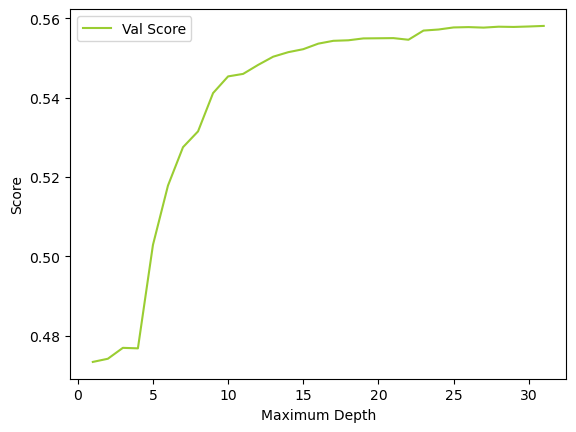

In [96]:
plt.plot(list(range(min, len(X_train.columns) + 1)), avg_val_scores, label="Val Score", color='yellowgreen')
plt.xlabel("Maximum Depth")
plt.ylabel("Score")
plt.legend()
plt.show()

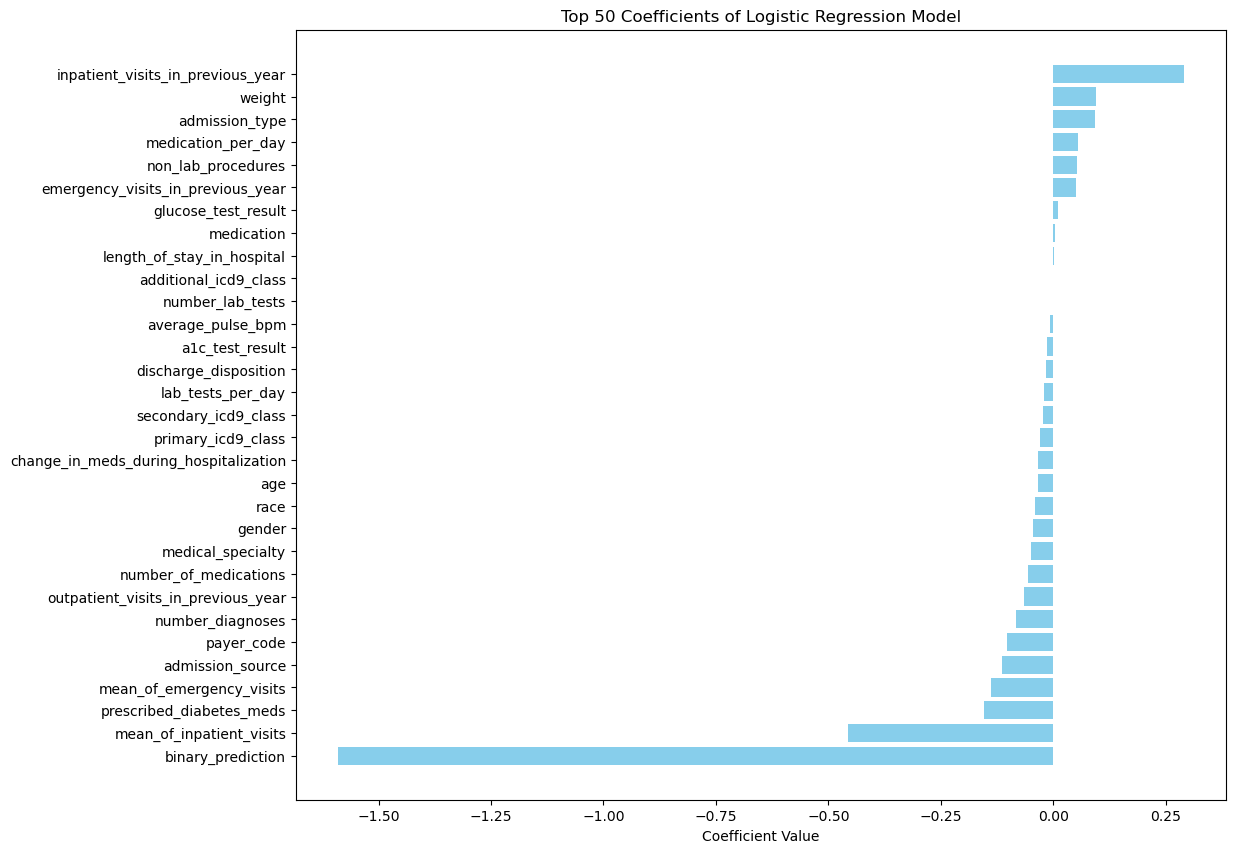

In [97]:
model.fit(X_train_rfe, y_train)
coef_df = pd.DataFrame({'feature': X_train.columns, 'coef': model.coef_[0]})
coef_df['abs_coef'] = np.abs(coef_df['coef'])

sorted_coef_df = coef_df.sort_values(by='coef', ascending=True)
sorted_coef_df = sorted_coef_df
# Plot the top 50 coefficients
plt.figure(figsize=(12, 10))
plt.barh(sorted_coef_df['feature'], sorted_coef_df['coef'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Top 50 Coefficients of Logistic Regression Model')
plt.show()

In [98]:
feature_selection['RFE_log'] = best_features_to_select.replace({True:1, False:0}) #1 if true to use for majority vote later on

In [99]:
#RFE RF

In [100]:
#we do the same for a decision tree

In [101]:
param_grid = {
    'max_depth': [3,6,9],
    'splitter' : ['random', 'best'],
    'criterion' : ['gini', 'entropy']
}
#min sample leafes shouldnt be relevant regarding size of dataset and max_depth parameters

min=1
# Variables to store results
avg_val_scores = []
best_params_list = []

for n in range(min, len(X_train.columns) + 1):
    model = DecisionTreeClassifier(random_state=0, class_weight='balanced')

    rfe = RFE(estimator=model, n_features_to_select=n)
    X_train_rfe = rfe.fit_transform(X_train, y_train)

    # Perform hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), scoring='f1_weighted')
    grid_search.fit(X_train_rfe, y_train)

    # Get the best hyperparameters from the grid search
    best_params = grid_search.best_params_
    best_params_list.append(best_params)

    # Use the best hyperparameters to train the model
    model = DecisionTreeClassifier(**best_params, random_state=0, class_weight='balanced')
    val_scores = cross_val_score(model, X_train_rfe, y_train, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), scoring='f1_weighted')
    
    # Store the average validation score
    avg_val_score = np.mean(val_scores)
    avg_val_scores.append(avg_val_score)
    print(avg_val_score)
    

best_nof_index = np.argmax(avg_val_scores)
best_nof = best_nof_index +  min 
best_params = best_params_list[best_nof_index]

model = DecisionTreeClassifier(**best_params, random_state=0, class_weight='balanced')
best_features_to_select = pd.Series(RFE(estimator=model, n_features_to_select=best_nof).fit(X_train, y_train).support_, index=X_train.columns)

print("Optimum number of features:", best_nof)
print("Best hyperparameters:", best_params)
print("Average validation score with %d features: %f" % (best_nof, avg_val_scores[best_nof_index]))
print(f"Best features to select: \n{best_features_to_select}")


0.32627702092469735
0.3269570303008293
0.3346663216913318
0.3891208146507084
0.4956828496845881
0.4966863279309043
0.5099780548653592
0.5083684055763078
0.5094999717098564
0.5162792666441346
0.5130378171464038
0.565263477199869
0.5629072846369632
0.5595344436811954
0.558719712027508
0.5543725461309807
0.5694496789652906
0.5718047493038394
0.5760201286741193
0.575531814109881
0.5725491015870432
0.5736117517111423
0.5827349252561029
0.5813607568313927
0.5813135346563476
0.5815685538104215
0.5767941753854308
0.5768780996886498
0.5817341982763176
0.5825264064899477
0.582685404889615
Optimum number of features: 23
Best hyperparameters: {'criterion': 'gini', 'max_depth': 9, 'splitter': 'best'}
Average validation score with 23 features: 0.582735
Best features to select: 
discharge_disposition                     True
secondary_icd9_class                      True
admission_type                            True
medication                                True
medical_specialty                    

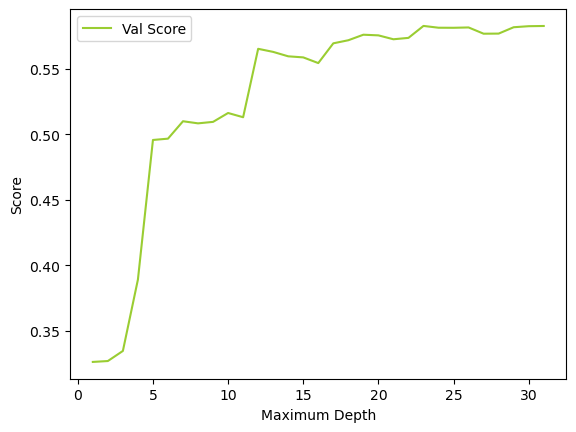

In [102]:
plt.plot(list(range(min, len(X_train.columns) + 1)), avg_val_scores, label="Val Score", color='yellowgreen')
plt.xlabel("Maximum Depth")
plt.ylabel("Score")
plt.legend()
plt.show()

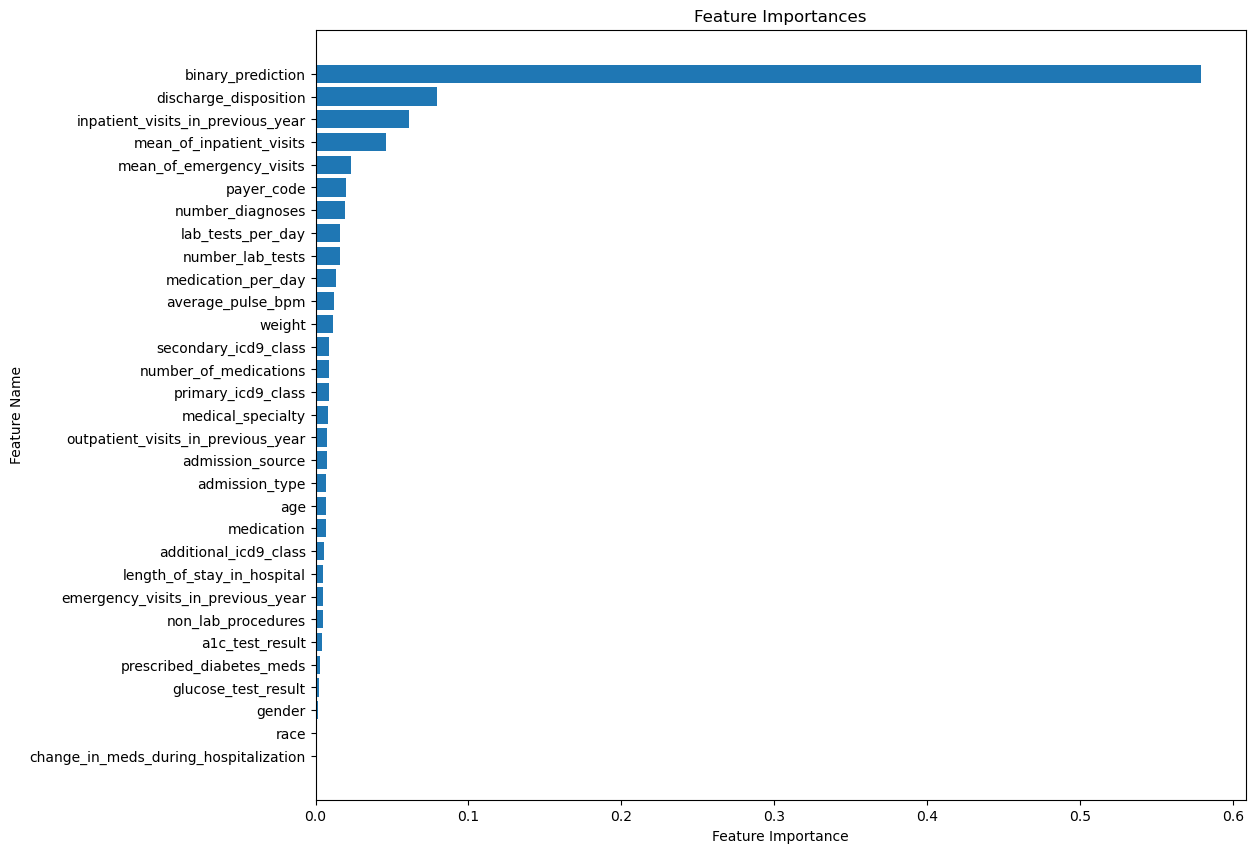

In [103]:
model.fit(X_train_rfe, y_train)
feature_importances = model.feature_importances_

sorted_indices = np.argsort(feature_importances)

if isinstance(X_train, pd.DataFrame):
    feature_names = X_train.columns
else:
    feature_names = [f"Feature_{i}" for i in range(X_train_num_scaled.shape[1])]

feature_names = feature_names[sorted_indices]

plt.figure(figsize=(12, 10))
plt.title("Feature Importances")
plt.barh(range(len(sorted_indices)), feature_importances[sorted_indices])
plt.yticks(range(len(sorted_indices)), feature_names) #, rotation=90
plt.ylabel("Feature Name")
plt.xlabel("Feature Importance")
plt.show()

In [104]:
feature_selection['RFE_dt'] = best_features_to_select.replace({True:1, False:0})

In [105]:
feature_selection['sum'] = feature_selection['sum'] + feature_selection['RFE_log'] + feature_selection['RFE_dt']

In [106]:
feature_selection.sort_values(by='sum', ascending=False)

Lasso_cv  Lasso_cv_>_0  sum  RFE_log  \
Feature                                                                       
binary_prediction                      0.649545             1    3        1   
primary_icd9_class                     0.008506             1    3        1   
weight                                -0.031956             1    3        1   
admission_type                        -0.026836             1    3        1   
non_lab_procedures                    -0.014305             1    3        1   
medication_per_day                    -0.013637             1    3        1   
length_of_stay_in_hospital            -0.001692             1    3        1   
number_lab_tests                       0.000295             1    3        1   
medication                             0.000447             1    3        1   
average_pulse_bpm                      0.000752             1    3        1   
lab_tests_per_day                      0.003567             1    3        1   
age                                    0.006328             1    3        1   
discharge_disposition                  0.006883             1    3        1   
mean_of_inpatient_visits               0.143080             1    3        1   
secondary_icd9_class                   0.007682             1    3        1   
mean_of_emergency_visits               0.011264             1    3        1   
number_of_medications                  0.013999             1    3        1   
medical_specialty                      0.017113             1    3        1   
outpatient_visits_in_previous_year     0.019331             1    3        1   
number_diagnoses                       0.024303             1    3        1   
payer_code                             0.030695             1    3        1   
admission_source                       0.031693             1    3        1   
inpatient_visits_in_previous_year     -0.101520             1    3        1   
race                                   0.012280             1    2        1   
emergency_visits_in_previous_year      0.012309             1    2        1   
a1c_test_result                        0.004851             1    2        1   
gender                                 0.013750             1    2        1   
change_in_meds_during_hospitalization  0.014609             1    2        1   
glucose_test_result                   -0.002517             1    2        1   
prescribed_diabetes_meds               0.047371             1    2        1   
additional_icd9_class                 -0.000000             0    1        1   

                                       RFE_dt  
Feature                                        
binary_prediction                           1  
primary_icd9_class                          1  
weight                                      1  
admission_type                              1  
non_lab_procedures                          1  
medication_per_day                          1  
length_of_stay_in_hospital                  1  
number_lab_tests                            1  
medication                                  1  
average_pulse_bpm                           1  
lab_tests_per_day                           1  
age                                         1  
discharge_disposition                       1  
mean_of_inpatient_visits                    1  
secondary_icd9_class                        1  
mean_of_emergency_visits                    1  
number_of_medications                       1  
medical_specialty                           1  
outpatient_visits_in_previous_year          1  
number_diagnoses                            1  
payer_code                                  1  
admission_source                            1  
inpatient_visits_in_previous_year           1  
race                                        0  
emergency_visits_in_previous_year           0  
a1c_test_result                             0  
gender                                      0  
change_in_meds_during_hospitalization  

In [107]:
feature_selection[feature_selection['sum']<2] #features to drop based on majority vote of all five methods (sum<3)

Lasso_cv  Lasso_cv_>_0  sum  RFE_log  RFE_dt
Feature                                                            
additional_icd9_class      -0.0             0    1        1       0

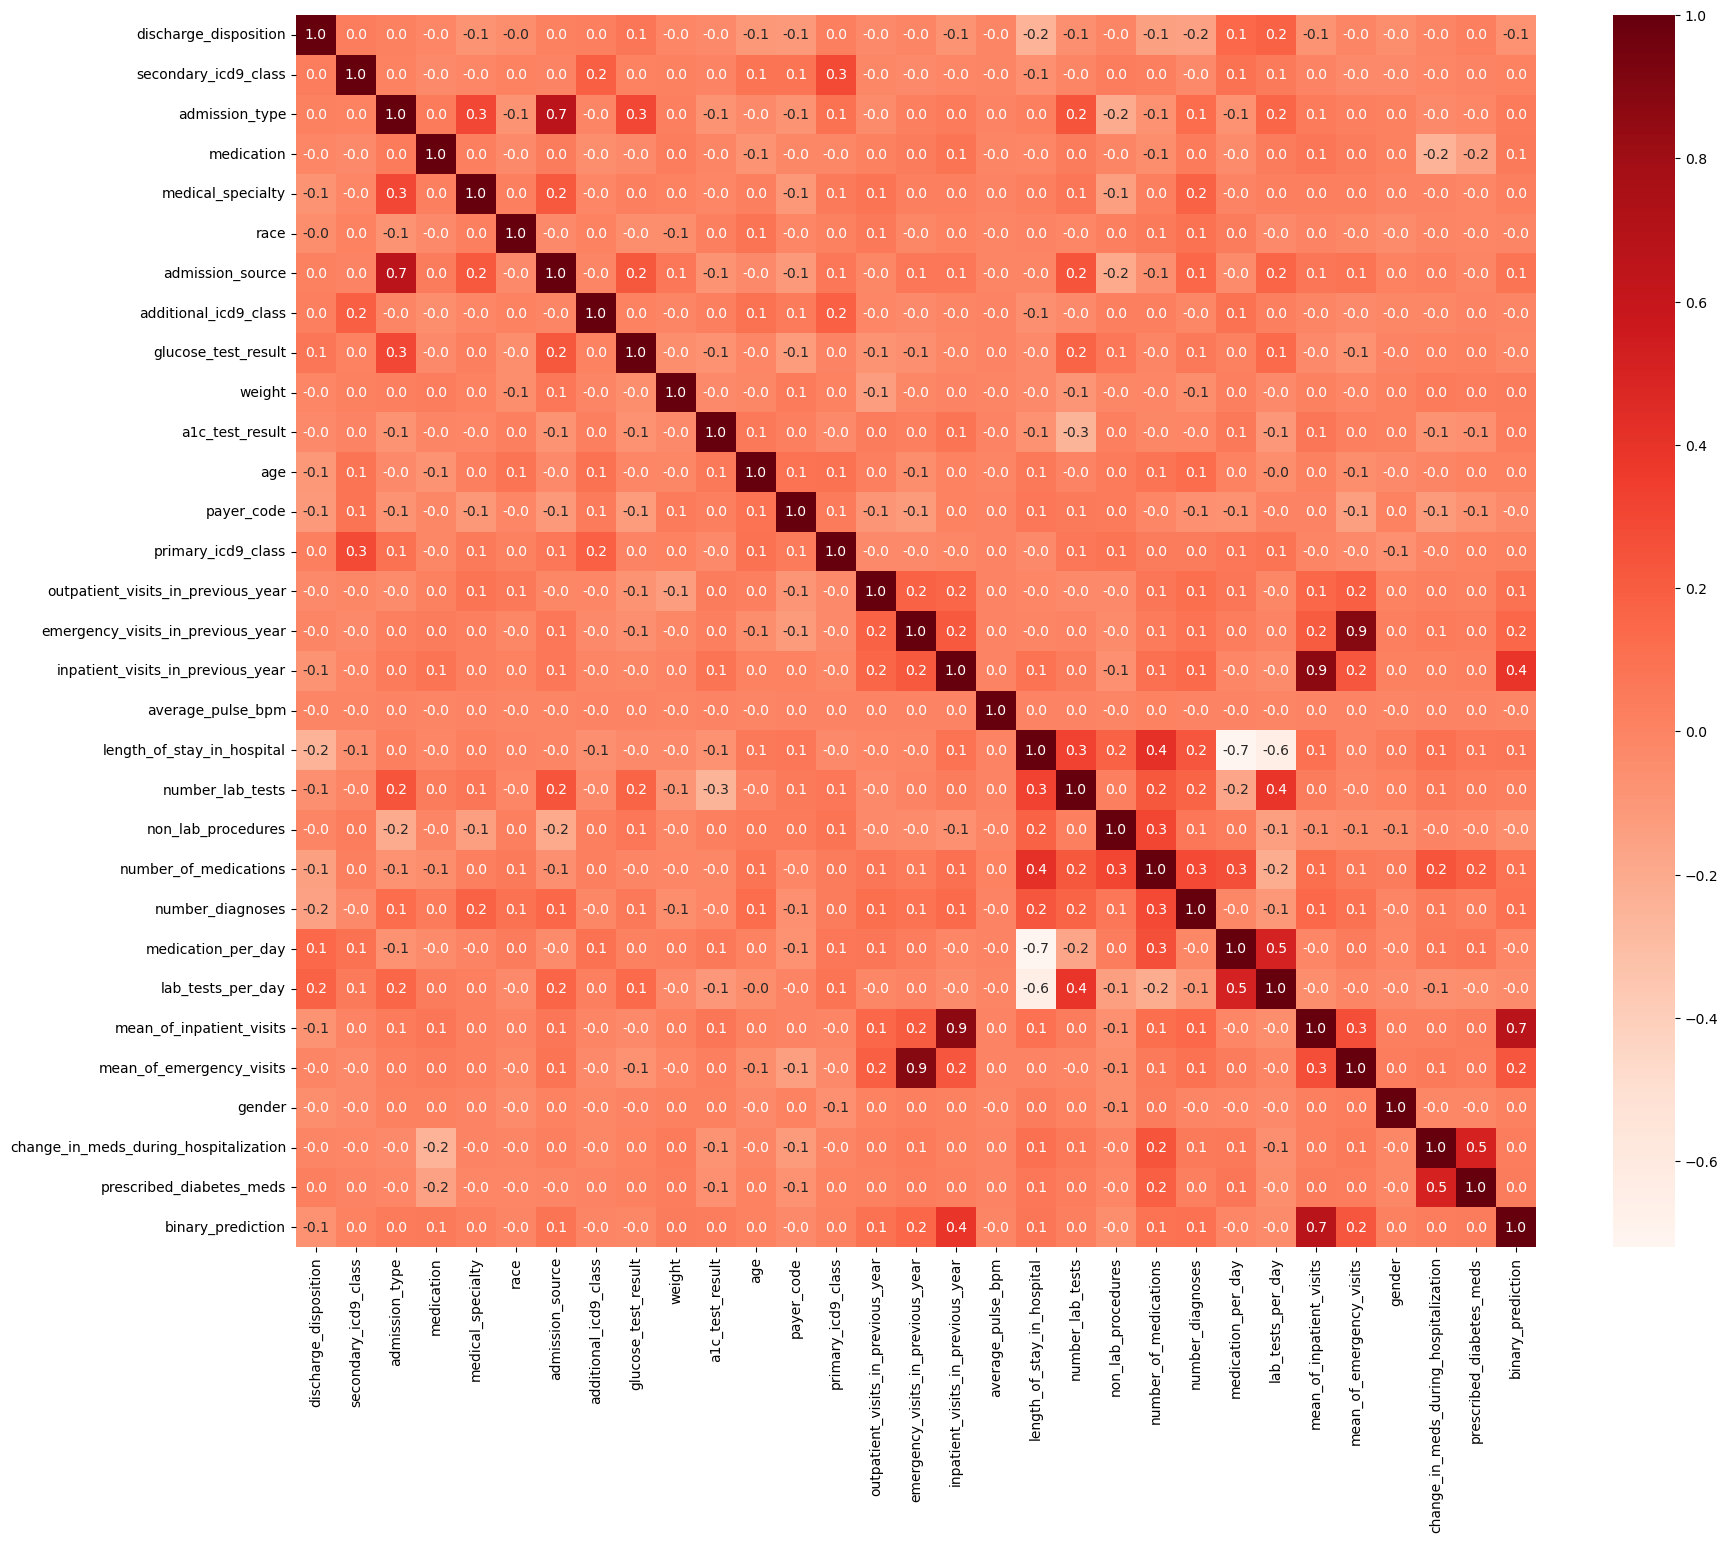

In [108]:
cor_spearman = X_train.corr(method ='spearman')
def cor_heatmap(cor):
    plt.figure(figsize=(20,16))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1f')
    plt.show()
cor_heatmap(cor_spearman)
#finally look at the correlations between input variables
#there are some relevant correlations we need to adress, but first drop the features based on the majority vote and see if we even have to
#adress the problems


In [109]:
#for multiclass we only drop lenght of stay in hospital because of high colinearity with target variable

In [110]:
X_train.drop(columns='length_of_stay_in_hospital', inplace=True) #drop features based on majority vote
X_val.drop(columns='length_of_stay_in_hospital', inplace=True)

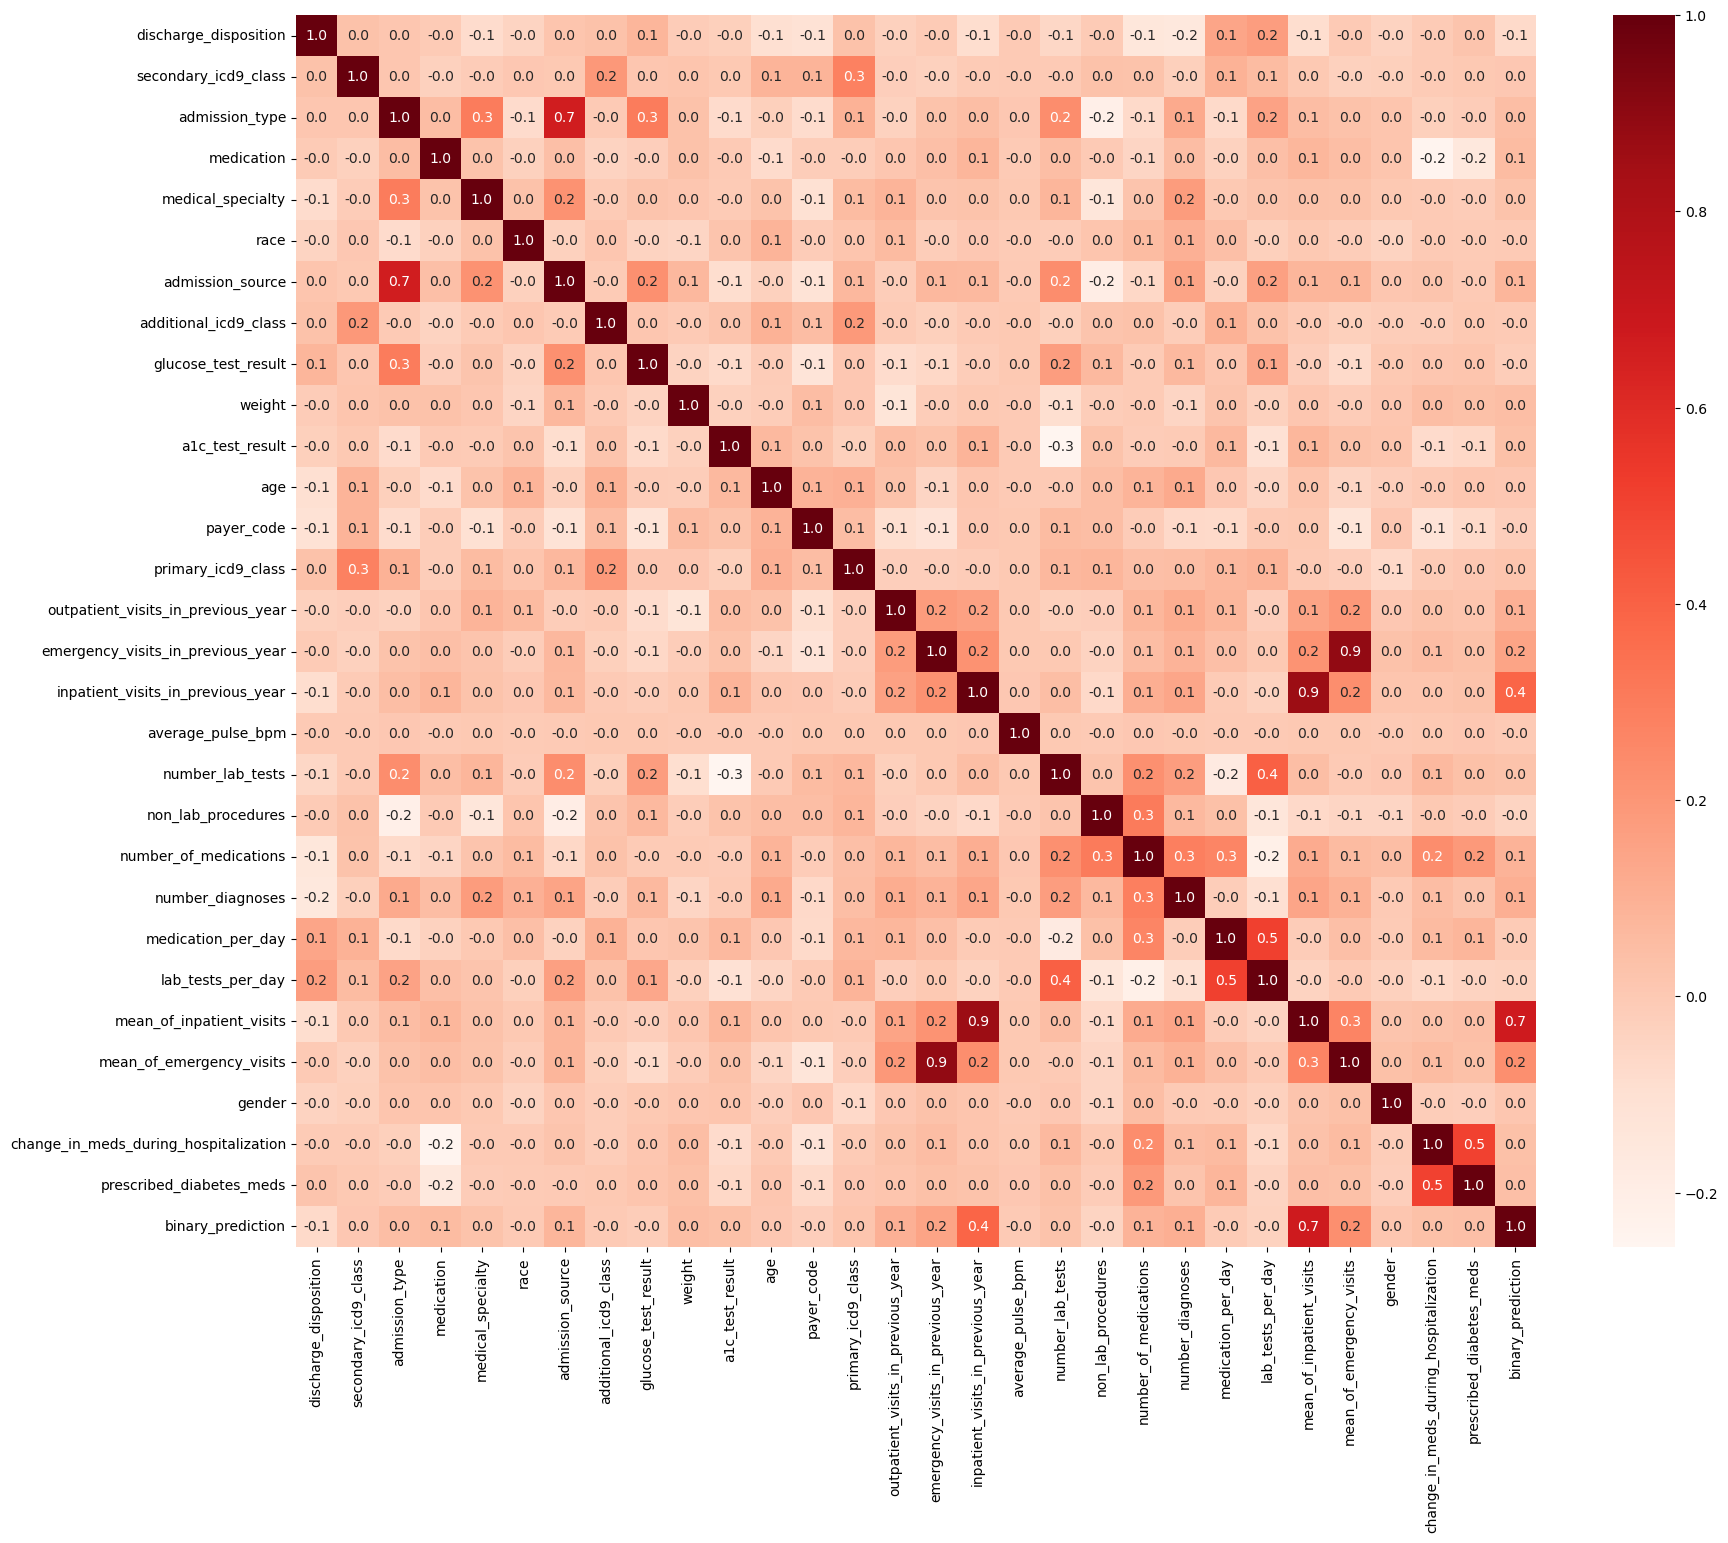

In [111]:
cor_spearman = X_train.corr(method ='spearman')
def cor_heatmap(cor):
    plt.figure(figsize=(20,16))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1f')
    plt.show()
cor_heatmap(cor_spearman)

#correlations after dropping features dropped out by majority vote
#only high correlation between mean visits and inpatient visits, which was expected
#still both models used so far seem to perform better if we use both variables so we keep them since they might still have a synergetic effect

In [112]:
X_train #final dataset

discharge_disposition  secondary_icd9_class  admission_type  \
encounter_id                                                                
369071                     0.822633             -1.014702        0.922527   
582754                    -1.059722              1.435686        0.922527   
969219                    -1.492475             -1.018956       -0.894782   
981571                    -1.024287             -0.531704        0.922527   
847718                     0.822633              1.435686        0.922527   
...                             ...                   ...             ...   
497792                     0.822633             -0.855475        0.922527   
719594                    -1.059722              1.435686        0.922527   
691024                     0.822633             -1.078362        0.922527   
321201                     0.822633              1.435686        0.922527   
227690                     0.822633              1.435686        0.922527   

              medication  medical_specialty      race  admission_source  \
encounter_id                                                              
369071         -1.016810           1.010378  0.632664          0.802059   
582754          1.159495          -0.968208  0.632664          0.802059   
969219          0.536334          -1.068643  0.632664         -0.626599   
981571          0.536334           1.010378  0.632664          0.802059   
847718          1.159495          -0.968208 -1.370925          0.802059   
...                  ...                ...       ...               ...   
497792         -1.112591           1.010378  0.632664          0.802059   
719594          0.536334           1.010378  0.632664          0.802059   
691024          1.159495           1.010378  0.632664          0.802059   
321201          1.159495           1.010378  0.632664          0.802059   
227690         -0.540981           1.010378  0.632664          0.802059   

              additional_icd9_class  glucose_test_result    weight  ...  \
encounter_id                                                        ...   
369071                    -0.979859             0.234643 -5.521554  ...   
582754                     1.402679             0.234643  0.180442  ...   
969219                    -0.452294             0.234643  0.180442  ...   
981571                    -1.153068             0.234643  0.180442  ...   
847718                     1.402679             0.234643  0.180442  ...   
...                             ...                  ...       ...  ...   
497792                    -0.661066             0.234643  0.180442  ...   
719594                    -0.700439             0.234643  0.180442  ...   
691024                    -1.099089             0.234643  0.180442  ...   
321201                     1.402679             0.234643  0.180442  ...   
227690                     1.402679             0.234643  0.180442  ...   

              number_of_medications  number_diagnoses  medication_per_day  \
encounter_id                                                                
369071                     0.273217          0.816714           -0.690445   
582754                    -0.180925          0.300471           -0.804011   
969219                    -1.543349          0.300471           -1.002750   
981571                    -0.786447          0.816714           -0.450697   
847718                    -0.483686         -0.732014           -0.274040   
...                             ...               ...                 ...   
497792                     0.121836          0.816714            0.079274   
719594                    -0.483686          0.816714           -0.539025   
691024                     1.181500          0.816714            1.713351   
321201                     2.241163          0.816714           -0.450697   
227690                     0.273217          0.816714            0.167603   

              lab_tests_per_day  mean_of_inpatient_visits 

Models

In [113]:
#logistic regression -> l1/l2, class_weight
#decision tree class_weight
#random forest class_weight
#histgradient boosting sample_weights
#sgd hinge/svc class_weight
#naive bayes sample_weights
#mlp SMOTE
#knn SMOTE



#we can see that rus has a loss of information for multiclass (see sgd, log reg, naive bayes) which is why we dont use it anymore

In [114]:
#strategy: we use grid search to find the best parameters, therefore we run the notebook multiple times and exchange the
#the parameter grids every time until we get close to an optimum

In [115]:
def gridsearch(estimator, param_grid, cv, fit_params=None, scoring ='f1_weighted', X_train = X_train, y_train=y_train):
    
    
    grid_search = GridSearchCV(estimator, param_grid, scoring=scoring, cv=cv)#, verbose=3
    
    if fit_params is not None:
        grid_search.fit(X_train, y_train, **fit_params)
    else:
        grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    best_params = {key.split('__', 1)[1] if '__' in key else key: value for key, value in best_params.items()} #for the RUS parameters
    best_score = grid_search.best_score_
    print("Best Parameters: ", best_params)
    print("Best F1: ", best_score)
    
    return best_params, best_score
    

In [116]:
def evaluate_estimator(estimator, y_train=y_train, y_val = y_val, X_train=X_train, X_val = X_val):
    train_pred = estimator.predict(X_train)
    test_pred = estimator.predict(X_val)
    cm = confusion_matrix(y_val, test_pred)
    train_error = f1_score(y_train, train_pred , average='weighted')
    test_error = f1_score(y_val, test_pred , average='weighted')
    print('Train Error F1', train_error) 
    print('Test Error F1', test_error)
    print(cm)
    
    return train_error, test_error, cm

In [117]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

Logistic Regression

In [118]:
#parameters from binary seem to work

In [119]:
lr_l1 = LogisticRegression(class_weight='balanced', random_state=0)

param_grid = {
    'solver': ['liblinear','saga'],
    'penalty': ['l1'],
    'C': np.arange(0.3,0.45,0.05)
}

lr_l1_best_params, lr_l1_best_score = gridsearch(lr_l1, param_grid, stratified_kfold)

Best Parameters:  {'C': 0.35, 'penalty': 'l1', 'solver': 'liblinear'}
Best F1:  0.6253691570622975


In [120]:
lr_l1 = LogisticRegression(**lr_l1_best_params, class_weight='balanced', random_state=0)
lr_l1.fit(X_train, y_train)
lr_l1_train_error, lr_l1_test_error,lr_l1_cm = evaluate_estimator(lr_l1)

Train Error F1 0.6264501277001928
Test Error F1 0.6191802844608726
[[6951  499  231]
 [2380 1823  774]
 [ 506  660  424]]


In [121]:
#also here paremters from binary are good

In [122]:
lr_l2 = LogisticRegression(class_weight='balanced', random_state=0)


param_grid = {
    'solver': ['lbfgs','liblinear','saga', 'newton-cg','newton-cholesky', 'saga'],
    'penalty': ['l2'],
    'C': np.arange(0.04,0.055,0.005)
}

lr_l2_best_params, lr_l2_best_score = gridsearch(lr_l2, param_grid, stratified_kfold)

Best Parameters:  {'C': 0.049999999999999996, 'penalty': 'l2', 'solver': 'liblinear'}
Best F1:  0.6256305532487588


In [123]:
lr_l2 = LogisticRegression(**lr_l2_best_params, class_weight='balanced', random_state=0)
lr_l2.fit(X_train, y_train)
lr_l2_train_error, lr_l2_test_error,lr_l2_cm = evaluate_estimator(lr_l2)


Train Error F1 0.6265420066981208
Test Error F1 0.619472214188609
[[6944  507  230]
 [2375 1828  774]
 [ 508  655  427]]


In [124]:
# param_grid = {
#     'logisticregression__solver': ['liblinear','saga'],
#     'logisticregression__penalty': ['l1'],
#     'logisticregression__C': [0.01, 0.05, 0.1, 0.5, 1]
# }

# param_grid = {
#     'logisticregression__solver': ['liblinear','saga'],
#     'logisticregression__penalty': ['l1'],
#     'logisticregression__C': np.arange(0.1, 0.6, 0.1)
# }

In [125]:
lr_l1_rus = make_pipeline(RandomUnderSampler(random_state=0), LogisticRegression(random_state=0))

param_grid = {
    'logisticregression__solver': ['liblinear','saga'],
    'logisticregression__penalty': ['l1'],
    'logisticregression__C': np.arange(0.25, 0.27, 0.005)
}

lr_l1_rus_best_params, lr_l1_rus_best_score = gridsearch(lr_l1_rus, param_grid, stratified_kfold)


Best Parameters:  {'C': 0.265, 'penalty': 'l1', 'solver': 'saga'}
Best F1:  0.5576752351863894


In [126]:
lr_l1_rus = make_pipeline(RandomUnderSampler(random_state=0), LogisticRegression(random_state=0, **lr_l1_rus_best_params))
lr_l1_rus.fit(X_train, y_train)
lr_l1_rus_train_error, lr_l1_rus_test_error,lr_l1_rus_cm = evaluate_estimator(lr_l1_rus)

Train Error F1 0.5585664195551813
Test Error F1 0.544153786575835
[[6627  523  531]
 [2126  732 2119]
 [ 461  166  963]]


In [127]:
# param_grid = {
#     'logisticregression__solver': ['lbfgs','liblinear','saga', 'newton-cg','newton-cholesky', 'saga'],
#     'logisticregression__penalty': ['l2'],
#     'logisticregression__C': [0.01, 0.05, 0.1, 0.5, 1]
# }
# param_grid = {
#     'logisticregression__solver': ['lbfgs','liblinear','saga', 'newton-cg','newton-cholesky', 'saga'],
#     'logisticregression__penalty': ['l2'],
#     'logisticregression__C': [1,2,3,4,5]
# }

In [128]:
lr_l2_rus = make_pipeline(RandomUnderSampler(random_state=0), LogisticRegression(random_state=0))

param_grid = {
    'logisticregression__solver': ['lbfgs','liblinear','saga', 'newton-cg','newton-cholesky', 'saga'],
    'logisticregression__penalty': ['l2'],
    'logisticregression__C': np.arange(0.01,0.05,0.01)
}

lr_l2_rus_best_params, lr_l2_rus_best_score = gridsearch(lr_l2_rus, param_grid, stratified_kfold)


Best Parameters:  {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
Best F1:  0.5630686198220072


In [129]:
lr_l2_rus = make_pipeline(RandomUnderSampler(random_state=0), LogisticRegression(random_state=0, **lr_l2_rus_best_params))
lr_l2_rus.fit(X_train, y_train)
lr_l2_rus_train_error, lr_l2_rus_test_error,lr_l2_rus_cm = evaluate_estimator(lr_l2_rus)

Train Error F1 0.5632666855614449
Test Error F1 0.5462652983764035
[[6572  562  547]
 [2096  776 2105]
 [ 458  174  958]]


Decision Tree

In [130]:
# param_grid = {
#     'max_depth': [2,3,4],
#     'min_samples_split': [2,3,4],
#     'min_samples_leaf': [2,3,4],
#     'splitter' : ['random', 'best'],
#     'criterion' : ['gini', 'entropy']
# }
# Best Parameters:  {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
# Best F1:  0.554039596400885
# Train Error F1 0.5696225284098113
# Test Error F1 0.5537420770625288

# param_grid = {
#     'max_depth': [4, 8, 12],
#     'min_samples_split': [2,3],
#     'min_samples_leaf': [2,3],
#     'splitter' : ['random', 'best'],
#     'criterion' : ['gini', 'entropy']
# }
# Best Parameters:  {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
# Best F1:  0.5819678924728717
# Train Error F1 0.5987893752067868
# Test Error F1 0.5657417636246415

# param_grid = {
#     'max_depth': [6,8,10],
#     'min_samples_split': [2,3],
#     'min_samples_leaf': [2,3],
#     'splitter' : ['random', 'best'],
#     'criterion' : ['gini', 'entropy']
# }
# Train Error F1 0.6097701494038733
# Test Error F1 0.5668891437104899

# param_grid = {
#     'max_depth': [10, 14,18,30],
#     'min_samples_split': [2,3],
#     'min_samples_leaf': [2,3],
#     'splitter' : ['random', 'best'],
#     'criterion' : ['gini', 'entropy']
# }
# Best Parameters:  {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'random'}
# Best F1:  0.5840741027115091
# Train Error F1 0.6033268278079732
# Test Error F1 0.5716566788419587

In [131]:
dt = DecisionTreeClassifier(class_weight='balanced', random_state=0)

param_grid = {
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [2],
    'splitter' : ['random'],
    'criterion' : ['gini']
}

dt_best_params, dt_best_score = gridsearch(dt, param_grid, stratified_kfold)

#f1 score doesnt change anymore, min sample leaf and min samples split dont matter, since max depth is only 3

Best Parameters:  {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'random'}
Best F1:  0.579131026371382


In [132]:
dt = DecisionTreeClassifier(random_state=0, **dt_best_params, class_weight='balanced')
dt.fit(X_train, y_train)
dt_train_error, dt_test_error,dt_cm = evaluate_estimator(dt)

Train Error F1 0.5993820376533685
Test Error F1 0.558556091610687
[[6072  824  785]
 [1807 1126 2044]
 [ 358  309  923]]


In [133]:
# param_grid = {
#     'decisiontreeclassifier__max_depth': [8,10,12],
#     'decisiontreeclassifier__min_samples_split': [2,3,4],
#     'decisiontreeclassifier__min_samples_leaf': [2,3,4],
#     'decisiontreeclassifier__splitter' : ['random', 'best'],
#     'decisiontreeclassifier__criterion' : ['gini', 'entropy']
    
# }
# Best Parameters:  {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 2, 'splitter': 'random'}
# Best F1:  0.5726438489595278
# Train Error F1 0.5923218413450645
# Test Error F1 0.5793945888273666

In [134]:
dt_rus = make_pipeline(RandomUnderSampler(random_state=0), DecisionTreeClassifier(random_state=0))

param_grid = {
    'decisiontreeclassifier__max_depth': [8,10,12],
    'decisiontreeclassifier__min_samples_split': [2,3,4],
    'decisiontreeclassifier__min_samples_leaf': [2,3,4],
    'decisiontreeclassifier__splitter' : ['random', 'best'],
    'decisiontreeclassifier__criterion' : ['gini', 'entropy']
    
}

dt_rus_best_params, dt_rus_best_score = gridsearch(dt_rus, param_grid, stratified_kfold)

Best Parameters:  {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'random'}
Best F1:  0.5806292112262043


In [135]:
dt_rus = make_pipeline(RandomUnderSampler(random_state=0), DecisionTreeClassifier(random_state=0, **dt_rus_best_params))
dt_rus.fit(X_train, y_train)
dt_rus_train_error, dt_rus_test_error, dt_rus_cm = evaluate_estimator(dt_rus)

Train Error F1 0.5995103313069877
Test Error F1 0.5651350982503563
[[5885 1025  771]
 [1828 1379 1770]
 [ 389  343  858]]


Random Forest

In [136]:
# param_grid = {
#     'n_estimators': [80, 100, 120],
#     'max_depth': [12,14,16],
#     'criterion': ['gini'], 
#     'max_features': [10,20,30],
#     'min_impurity_decrease' : [0.0001],
#     'min_samples_split' : [20,50],
#     'min_samples_split' : [20,50],
# }
# Best Parameters:  {'criterion': 'gini', 'max_depth': 16, 'max_features': 30, 'min_impurity_decrease': 0.0001, 'min_samples_split': 20, 'n_estimators': 80}
# Best F1:  0.6370133145525705
# Train Error F1 0.7336156690227036
# Test Error F1 0.6185862426275137

# param_grid = {
#     'n_estimators': [70,80,90],
#     'max_depth': [15,17,19],
#     'criterion': ['gini'], 
#     'max_features': [30],
#     'min_impurity_decrease' : [0.0001],
#     'min_samples_split' : [20,50],
#     'min_samples_split' : [20,50],
# }
# Best Parameters:  {'criterion': 'gini', 'max_depth': 19, 'max_features': 30, 'min_impurity_decrease': 0.0001, 'min_samples_split': 20, 'n_estimators': 90}
# Best F1:  0.6417834200623391
# Train Error F1 0.7464774854236014
# Test Error F1 0.6245084723024217

# param_grid = {
#     'n_estimators': [90,110,130],
#     'max_depth': [19,20,21],
#     'criterion': ['gini'], 
#     'max_features': [30],
#     'min_impurity_decrease' : [0.0001]
#     # 'min_samples_split' : [20,50],
#     # 'min_samples_split' : [20,50],
# }
# Best Parameters:  {'criterion': 'gini', 'max_depth': 21, 'max_features': 30, 'min_impurity_decrease': 0.0001, 'n_estimators': 130}
# Best F1:  0.6458281968467185
# Train Error F1 0.7630912108330582
# Test Error F1 0.6286921176823577

# param_grid = {
#     'n_estimators': [130,150],
#     'max_depth': [22,24,26],
#     'criterion': ['gini'], 
#     'max_features': [30],
#     'min_impurity_decrease' : [0.0001]
#     # 'min_samples_split' : [20,50],
#     # 'min_samples_split' : [20,50],
# }
# Best Parameters:  {'criterion': 'gini', 'max_depth': 22, 'max_features': 30, 'min_impurity_decrease': 0.0001, 'n_estimators': 150}
# Best F1:  0.6468824935447032
# Train Error F1 0.7643526699699166
# Test Error F1 0.6298638640547758

# param_grid = {
#     'n_estimators': [150,170,200],
#     'max_depth': [22],
#     'criterion': ['gini'], 
#     'max_features': [30],
#     'min_impurity_decrease' : [0.0001]
#     # 'min_samples_split' : [20,50],
#     # 'min_samples_split' : [20,50],
# }
# Best Parameters:  {'criterion': 'gini', 'max_depth': 22, 'max_features': 30, 'min_impurity_decrease': 0.0001, 'n_estimators': 200}
# Best F1:  0.6471513340002394
# Train Error F1 0.7651247061435267
# Test Error F1 0.6296778061270195


# param_grid = {
#     'n_estimators': [200,220],
#     'max_depth': [22,23],
#     'criterion': ['gini'], 
#     'max_features': [30],
#     'min_impurity_decrease' : [0.0001]
#     # 'min_samples_split' : [20,50],
#     # 'min_samples_split' : [20,50],
# }
# Best Parameters:  {'criterion': 'gini', 'max_depth': 23, 'max_features': 30, 'min_impurity_decrease': 0.0001, 'n_estimators': 200}
# Best F1:  0.647211200804249
# Train Error F1 0.7657169822506351
# Test Error F1 0.630268532789506

In [137]:
rf = RandomForestClassifier(class_weight='balanced', random_state=0)

param_grid = {
    'n_estimators': [200],
    'max_depth': [23],
    'criterion': ['gini'], 
    'max_features': [30],
    'min_impurity_decrease' : [0.0001]
}
rf_best_params, rf_best_score = gridsearch(rf, param_grid, stratified_kfold)

Best Parameters:  {'criterion': 'gini', 'max_depth': 23, 'max_features': 30, 'min_impurity_decrease': 0.0001, 'n_estimators': 200}
Best F1:  0.6465680067602172


In [138]:
rf = RandomForestClassifier(random_state=0, **rf_best_params, class_weight='balanced')
rf.fit(X_train, y_train)
rf_train_error, rf_test_error,rf_cm= evaluate_estimator(rf)

Train Error F1 0.7657604677159601
Test Error F1 0.6308459997667037
[[6388 1119  174]
 [1867 2214  896]
 [ 396  668  526]]


HistgradientBoosting

In [139]:
# param_grid = {
#     'learning_rate': [0.0005, 0.001, 0.003],
#     'max_iter': [150,200, 250],
#     'max_depth': [1,2,3,4]
# }
# Best Parameters:  {'learning_rate': 0.003, 'max_depth': 4, 'max_iter': 250}
# Best F1:  0.5529443441249987
# Train Error F1 0.5564474709419205
# Test Error F1 0.5275221087818308


# param_grid = {
#     'learning_rate': [0.01, 0.1],
#     'max_iter': [150,200, 250],
#     'max_depth': [3,4,5]
# }
# Best Parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'max_iter': 150}
# Best F1:  0.6047092669221676
# Train Error F1 0.6399964733925629
# Test Error F1 0.5894091795879965

#overfitting
# param_grid = {
#     'learning_rate': [0.08, 0.12],
#     'max_iter': [100,150],
#     'max_depth': [4,6,8]
# }
# Best Parameters:  {'learning_rate': 0.12, 'max_depth': 8, 'max_iter': 100}
# Best F1:  0.6077440454959457
# Train Error F1 0.6467737476706242
# Test Error F1 0.5885936018177351

# param_grid = {
#     'learning_rate': [0.05, 0.1],
#     'max_iter': [120, 150, 300],
#     'max_depth': [3,4,5]
# }
# Best Parameters:  {'learning_rate': 0.1, 'max_depth': 5, 'max_iter': 120}
# Best F1:  0.6047092669221676
#if we take outer ranges we overfit again we keep it like that

# param_grid = {
#     'learning_rate': [0.2, 0.3, 0.4],
#     'max_iter': [80,100, 150],
#     'max_depth': [5,6,7]
# }
# Best Parameters:  {'learning_rate': 0.2, 'max_depth': 6, 'max_iter': 80}
# Best F1:  0.6097181990280808
# Train Error F1 0.6538199845057232
# Test Error F1 0.593272398121148

# param_grid = {
#     'learning_rate': [0.3,0.5],
#     'max_iter': [400],
#     'max_depth': [6,7]
# }
# Best Parameters:  {'learning_rate': 0.3, 'max_depth': 6, 'max_iter': 400}
# Best F1:  0.6077166077859065
# Train Error F1 0.657412215863343
# Test Error F1 0.5983795213279522

In [140]:
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
fit_params = {'sample_weight': sample_weights}
hgb = HistGradientBoostingClassifier(random_state=0)

param_grid = {
    'learning_rate': [0.3],
    'max_iter': [400],
    'max_depth': [6]
}

hgb_best_params, hgb_best_score = gridsearch(hgb, param_grid, stratified_kfold, fit_params=fit_params)

Best Parameters:  {'learning_rate': 0.3, 'max_depth': 6, 'max_iter': 400}
Best F1:  0.6077166077859065


In [141]:
hgb = HistGradientBoostingClassifier(random_state=0,**hgb_best_params)
hgb.fit(X_train, y_train, sample_weights)
hgb_train_error, hgb_test_error, hgb_cm = evaluate_estimator(hgb)

Train Error F1 0.657412215863343
Test Error F1 0.5983795213279522
[[6252  957  472]
 [1731 1528 1718]
 [ 368  360  862]]


SVM

In [142]:
#parameters from binary fit

In [143]:
sgd = SGDClassifier(loss='hinge', class_weight='balanced', random_state=0)

c = np.arange(0.0005, 0.0016, 0.0001)
alpha = 1/(c*len(X_train))

param_grid = {
    'alpha': alpha
}

print(1/(len(X_train)*0.0194972820788782))# opt c

sgd_best_params, sgd_best_score = gridsearch(sgd, param_grid, stratified_kfold)

0.0009000000000000002
Best Parameters:  {'alpha': 0.012533967050707414}
Best F1:  0.6178561808396521


In [144]:
sgd = SGDClassifier(loss='hinge', class_weight='balanced', random_state=0, **sgd_best_params)
sgd.fit(X_train, y_train)
sgd_train_error, sgd_test_error, sgd_cm = evaluate_estimator(sgd)

Train Error F1 0.6176420104721322
Test Error F1 0.6177418548567832
[[7063  603   15]
 [2524 2246  207]
 [ 530  963   97]]


In [145]:
# c = np.array([0.0001, 0.001, 0.01, 0.1, 1, 10, 100])
# alpha = 1/(c*len(X_train))
# Best Parameters:  {'alpha': 1.7547553870990382e-05}
# Best F1:  0.5364473531830979
# Train Error F1 0.540126972279554
# Test Error F1 0.5382960014133751

In [146]:
sgd_rus = make_pipeline(RandomUnderSampler(random_state=0), SGDClassifier(loss='hinge', random_state=0))

c = np.array([0.05, 1, 5])
alpha = 1/(c*len(X_train))

param_grid = {
    'sgdclassifier__alpha': alpha
}

sgd_rus_best_params, sgd_rus_best_score = gridsearch(sgd_rus, param_grid, stratified_kfold)



Best Parameters:  {'alpha': 1.7547553870990382e-05}
Best F1:  0.5364473531830979


In [147]:
sgd_rus = make_pipeline(RandomUnderSampler(random_state=0), SGDClassifier(loss='hinge', random_state=0, **sgd_rus_best_params))
sgd_rus.fit(X_train, y_train)
sgd_rus_train_error, sgd_rus_test_error, sgd_rus_cm = evaluate_estimator(sgd_rus)

Train Error F1 0.540126972279554
Test Error F1 0.5382960014133751
[[6421  557  703]
 [2228  861 1888]
 [ 519  245  826]]


In [148]:
# svc= SVC(class_weight='balanced', random_state=0, kernel='rbf')
# param_grid = {
#     'gamma': ['auto'],
#     'C' : [0.1,1,2,3]
# }
# Best Parameters:  {'C': 3, 'gamma': 'auto'}
# Best F1:  0.6052086283464793
# Train Error F1 0.6937447321487482
# Test Error F1 0.601337462681217
#overfitting but model wants still higher values of c

# param_grid = {
#     'gamma': ['auto'],
#     'C' : [0.01,5,10]
# }
# Best Parameters:  {'C': 5, 'gamma': 'auto'}
# Best F1:  0.6066036178141353
# Train Error F1 0.7278643607766774
# Test Error F1 0.6031508499301774
#overfitting on train data but still improving the test error

In [149]:
svc= SVC(class_weight='balanced', random_state=0, kernel='rbf')
param_grid = {
    'gamma': ['auto'],
    'C' : [5]
}

svc_best_params, svc_best_score = gridsearch(svc, param_grid, stratified_kfold)

Best Parameters:  {'C': 5, 'gamma': 'auto'}
Best F1:  0.6066036178141353


In [150]:
svc = SVC(class_weight='balanced', random_state=0, **svc_best_params, kernel='rbf')
svc.fit(X_train, y_train)
svc_train_error, svc_test_error, svc_cm = evaluate_estimator(svc)

Train Error F1 0.7278643607766774
Test Error F1 0.6031508499301774
[[6414  878  389]
 [1935 1666 1376]
 [ 431  480  679]]


Naive Bayes

In [151]:
param_grid = {}
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
fit_params = {'sample_weight': sample_weights}
#CategoricalNB,MultinomialNB doesnt work since we used stadard scaler and it cant take negative values

In [152]:
bnb = BernoulliNB()
bnb_best_params, bnb_best_score = gridsearch(bnb, param_grid, stratified_kfold, fit_params=fit_params)
bnb.fit(X_train, y_train, sample_weights)
bnb_train_error, bnb_test_error, bnb_cm = evaluate_estimator(bnb)

Best Parameters:  {}
Best F1:  0.5356303571888804
Train Error F1 0.5353932068603567
Test Error F1 0.5331433602588468
[[6079  734  868]
 [1839  814 2324]
 [ 396  191 1003]]


In [153]:
gnb = GaussianNB()
gnb_best_params, gnb_best_score = gridsearch(gnb, param_grid, stratified_kfold, fit_params=fit_params)
gnb.fit(X_train, y_train, sample_weights)
gnb_train_error, gnb_test_error, gnb_cm = evaluate_estimator(gnb)

Best Parameters:  {}
Best F1:  0.5700917744736435
Train Error F1 0.5706104244181182
Test Error F1 0.5560381963404171
[[6321  647  713]
 [1998 1026 1953]
 [ 433  285  872]]


In [154]:
bnb_rus = make_pipeline(RandomUnderSampler(random_state=0), BernoulliNB())
bnb_rus_best_params, bnb_rus_best_score = gridsearch(bnb_rus, param_grid, stratified_kfold)
bnb_rus.fit(X_train, y_train)
bnb_rus_train_error, bnb_rus_test_error, bnb_rus_cm = evaluate_estimator(bnb_rus)

Best Parameters:  {}
Best F1:  0.5356441290916873
Train Error F1 0.5330206434874801
Test Error F1 0.530811851582372
[[6066  755  860]
 [1839  795 2343]
 [ 401  178 1011]]


In [155]:
gnb_rus = make_pipeline(RandomUnderSampler(random_state=0), GaussianNB())
gnb_rus_best_params, gnb_rus_best_score = gridsearch(gnb_rus, param_grid, stratified_kfold)
gnb_rus.fit(X_train, y_train)
gnb_rus_train_error, gnb_rus_test_error, gnb_rus_cm = evaluate_estimator(gnb_rus)

Best Parameters:  {}
Best F1:  0.5703373759464243
Train Error F1 0.5688758024915106
Test Error F1 0.554482960621717
[[6317  649  715]
 [1993 1001 1983]
 [ 434  266  890]]


MLP

In [156]:
# param_grid = {
#     'mlpclassifier__hidden_layer_sizes': [(ncol,), (ncol, int((ncol/2)))],
#     'mlpclassifier__activation': ['relu', 'logistic', 'tanh'],
#     'mlpclassifier__alpha': [0.01, 0.05, 0.1],
#     'mlpclassifier__solver': ['adam', 'sgd'],
#     'mlpclassifier__max_iter' : [400]
# }
# Best Parameters:  {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (30,), 'max_iter': 400, 'solver': 'adam'}
# Best F1:  0.5813474294047654
# Train Error F1 0.5973246143082652
# Test Error F1 0.5814763418832595

# param_grid = {
#     'mlpclassifier__hidden_layer_sizes': [(ncol,), (ncol, int((ncol/2)))],
#     'mlpclassifier__activation': ['relu'],
#     'mlpclassifier__alpha': [0.03, 0.05, 0.07],
#     'mlpclassifier__solver': ['adam'],
#     'mlpclassifier__max_iter' : [400]
# }
# Best Parameters:  {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (30,), 'max_iter': 400, 'solver': 'adam'}
# Best F1:  0.6055052215668809
# Train Error F1 0.6271810376587384
# Test Error F1 0.6069953382725671

In [157]:
ncol = len(X_train.columns)
param_grid = {
    'mlpclassifier__hidden_layer_sizes': [(ncol,)],
    'mlpclassifier__activation': ['relu'],
    'mlpclassifier__alpha': [0.05],
    'mlpclassifier__solver': ['adam'],
    'mlpclassifier__max_iter' : [400]
}
# 
mlp_smote = make_pipeline(SMOTE(random_state=0), MLPClassifier(random_state=0))
mlp_smote_best_params, mlp_smote_best_score = gridsearch(mlp_smote, param_grid, stratified_kfold)

Best Parameters:  {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (30,), 'max_iter': 400, 'solver': 'adam'}
Best F1:  0.6022875674392844


In [158]:
mlp_smote = make_pipeline(SMOTE(random_state=0), MLPClassifier(random_state=0, **mlp_smote_best_params))
mlp_smote.fit(X_train, y_train)
mlp_smote_train_error, mlp_smote_test_error, mlp_smote_cm = evaluate_estimator(mlp_smote)

Train Error F1 0.6117220423289924
Test Error F1 0.5954065664629965
[[6052 1007  622]
 [1803 1814 1360]
 [ 404  542  644]]


KNN

In [159]:
#error with skikit learn version regarding thread 
#https://github.com/scikit-learn/scikit-learn/issues/26768

knn_smote = make_pipeline(RandomOverSampler(random_state=0), KNeighborsClassifier())
from sklearn.neighbors import KNeighborsClassifier
param_grid = {
    'kneighborsclassifier__n_neighbors': np.arange(19,22,1),
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__p': [1, 2]                      
}

knn_smote_best_params, knn_smote_best_score = gridsearch(knn_smote, param_grid, stratified_kfold)
#error in skikit learn

Best Parameters:  {'n_neighbors': 21, 'p': 1, 'weights': 'distance'}
Best F1:  0.5444044241482341


In [160]:
model_data = {
    'Model': ['Logistic Regression (L1)', 'Logistic Regression (L2)', 'Logistic Regression (L1 RUS)', 'Logistic Regression (L2 RUS)', 'Decision Tree', 'Decision Tree (RUS)', 'Random Forest', 'HistGradient Boosting', 'SVM', 'SVM (RUS)', 'SVC', 'BernoulliNB', 'BernoulliNB (RUS)', 'GaussianNB', 'GaussianNB (RUS)', 'MLP (SMOTE)'],
    'Train F1 Score': [lr_l1_train_error, lr_l2_train_error, lr_l1_rus_train_error, lr_l2_rus_train_error, dt_train_error, dt_rus_train_error, rf_train_error,  hgb_train_error, sgd_train_error, sgd_rus_train_error, svc_train_error, bnb_train_error, bnb_rus_train_error, gnb_train_error, gnb_rus_train_error, mlp_smote_train_error],
    'Test F1 Score': [lr_l1_test_error, lr_l2_test_error, lr_l1_rus_test_error, lr_l2_rus_test_error, dt_test_error, dt_rus_test_error, rf_test_error,  hgb_test_error,  sgd_test_error, sgd_rus_test_error, svc_test_error,  bnb_test_error, bnb_rus_test_error, gnb_test_error, gnb_rus_test_error, mlp_smote_test_error],
    'CV Score': [lr_l1_best_score, lr_l2_best_score, lr_l1_rus_best_score, lr_l2_rus_best_score, dt_best_score, dt_rus_best_score, rf_best_score, hgb_best_score,  sgd_best_score, sgd_rus_best_score, svc_best_score,  bnb_best_score, bnb_rus_best_score, gnb_best_score, gnb_rus_best_score, mlp_smote_best_score]
}

model_df = pd.DataFrame(model_data)

# Displaying the DataFrame
print(model_df)

                           Model  Train F1 Score  Test F1 Score  CV Score
0       Logistic Regression (L1)        0.626450       0.619180  0.625369
1       Logistic Regression (L2)        0.626542       0.619472  0.625631
2   Logistic Regression (L1 RUS)        0.558566       0.544154  0.557675
3   Logistic Regression (L2 RUS)        0.563267       0.546265  0.563069
4                  Decision Tree        0.599382       0.558556  0.579131
5            Decision Tree (RUS)        0.599510       0.565135  0.580629
6                  Random Forest        0.765760       0.630846  0.646568
7          HistGradient Boosting        0.657412       0.598380  0.607717
8                            SVM        0.617642       0.617742  0.617856
9                      SVM (RUS)        0.540127       0.538296  0.536447
10                           SVC        0.727864       0.603151  0.606604
11                   BernoulliNB        0.535393       0.533143  0.535630
12             BernoulliNB (RUS)      

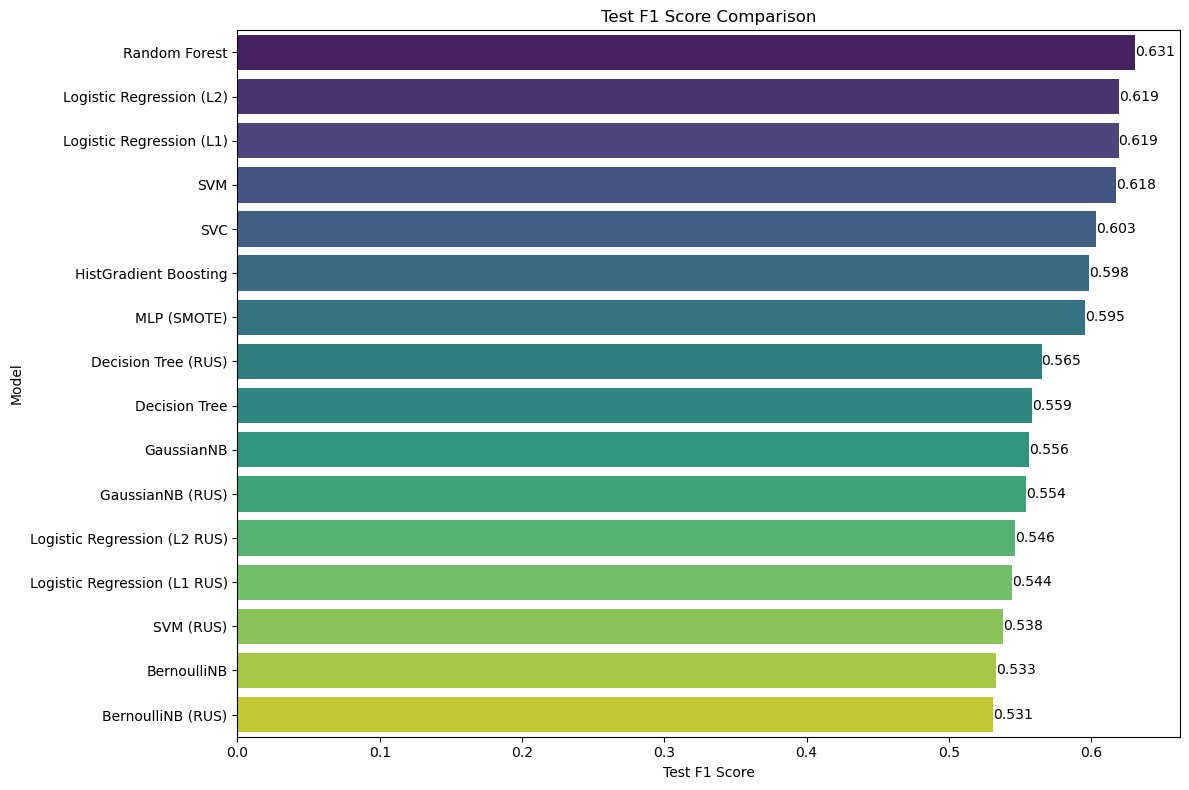

In [162]:
# Set the color palette to 'viridis'
sns.set_palette('viridis')

# Order the DataFrame by Test F1 Score
model_df_sorted = model_df.sort_values(by='Test F1 Score', ascending=False)

# Create a horizontal bar plot for Test F1 Score
plt.figure(figsize=(12, 8))
bar_plot = sns.barplot(x='Test F1 Score', y='Model', data=model_df_sorted, label='Test F1 Score', palette='viridis')

# Add labels and title
plt.xlabel('Test F1 Score')
plt.ylabel('Model')
plt.title('Test F1 Score Comparison')

# Add F1 score values on each bar
for index, value in enumerate(model_df_sorted['Test F1 Score']):
    bar_plot.text(value, index, f'{value:.3f}', color='black', ha="left", va="center", fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()